# Imports

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from scipy.spatial.distance import pdist, squareform

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

# Data Investigation

In [2]:
# Load connections data (filtered) with columns: pre_root_id, post_root_id, syn_count, etc.
connections = pd.read_csv('data/all/connections.csv')

# Load cell size measurements; expected columns: root_id, length_nm, area_nm, size_nm
cell_size = pd.read_csv('data/all/cell_stats.csv')

# Load classification annotations; expected columns: root_id, label
labels_df = pd.read_csv('data/all/classification.csv')

## Investigating Connections

Head of the Connections dataset:
          pre_root_id        post_root_id neuropil  syn_count nt_type
0  720575940629970489  720575940631267655   AVLP_R          7    GABA
1  720575940605876866  720575940606514878    LAL_R         15    GABA
2  720575940627737365  720575940628914436     AL_L         32     ACH
3  720575940633587552  720575940626452879    SMP_R         15     ACH
4  720575940616871878  720575940621203973   AVLP_L         13    GABA

Shape of connections dataset: (3869878, 5)
Unique pre_root_id count: 129351
Unique post_root_id count: 125192

Synapse Count Statistics:
count    3.869878e+06
mean     8.825489e+00
std      1.300126e+01
min      1.000000e+00
25%      4.000000e+00
50%      6.000000e+00
75%      1.000000e+01
max      2.405000e+03
Name: syn_count, dtype: float64


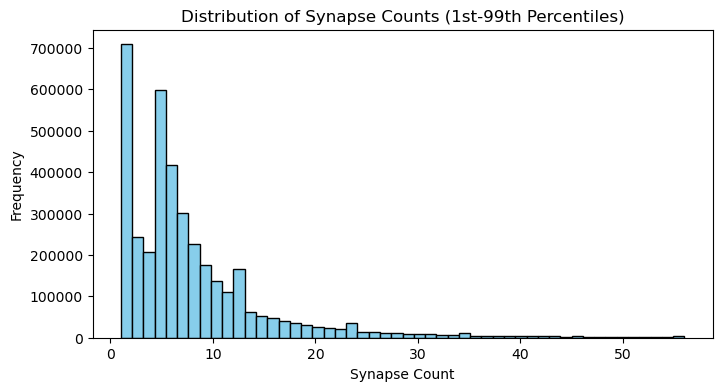

In [3]:
print("Head of the Connections dataset:")
print(connections.head())

print("\nShape of connections dataset:", connections.shape)
print("Unique pre_root_id count:", connections['pre_root_id'].nunique())
print("Unique post_root_id count:", connections['post_root_id'].nunique())
print("\nSynapse Count Statistics:")
print(connections['syn_count'].describe())

# Compute the 1st and 99th percentiles for 'syn_count'
q_low = connections['syn_count'].quantile(0.01)
q_high = connections['syn_count'].quantile(0.99)

# Filter out outliers
filtered_syn_counts = connections['syn_count'][(connections['syn_count'] >= q_low) & (connections['syn_count'] <= q_high)]

# Plot the histogram without outliers
plt.figure(figsize=(8, 4))
plt.hist(filtered_syn_counts, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Synapse Counts (1st-99th Percentiles)")
plt.xlabel("Synapse Count")
plt.ylabel("Frequency")
plt.show()

Here, excluded some outliers as there are some extreme instances, such as a case with a synapse count of 2405! Without excluding such instances, the graph ceases to remain interpretable.

## Investigating Cell Sizes

Head of the Cell Size dataset:
              root_id  length_nm     area_nm       size_nm
0  720575940596125868     396840   628299136   37616302080
1  720575940597856265    1184013  1634424448  100004290560
2  720575940597944841     784742  1022307072   58954229760
3  720575940598267657    1645960  2346787840  140744601600
4  720575940599333574     575383  1366784768  111170764800

Shape of cell size dataset: (139246, 4)

Length (nm) Statistics:
count    1.392460e+05
mean     1.071596e+06
std      1.738372e+06
min      4.930000e+03
25%      3.890615e+05
50%      6.125170e+05
75%      1.123870e+06
max      1.037336e+08
Name: length_nm, dtype: float64

Area (nm) Statistics:
count    1.392460e+05
mean     1.990228e+09
std      3.296213e+09
min      1.514189e+07
25%      7.147744e+08
50%      1.142385e+09
75%      2.054552e+09
max      2.581138e+11
Name: area_nm, dtype: float64

Volume/Size (nm) Statistics:
count    1.392460e+05
mean     1.400852e+11
std      2.485215e+11
min      4.27591

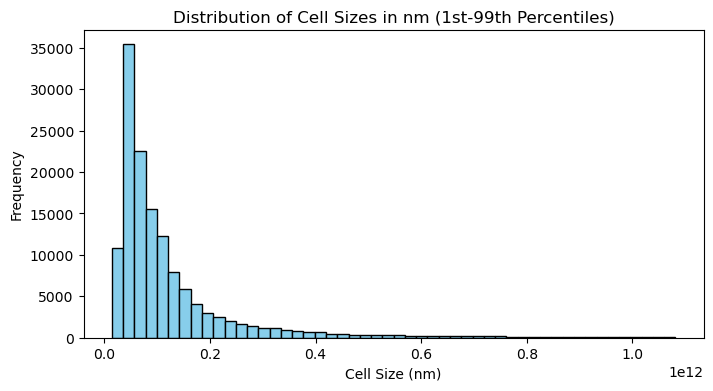

In [4]:
print("Head of the Cell Size dataset:")
print(cell_size.head())

print("\nShape of cell size dataset:", cell_size.shape)
print("\nLength (nm) Statistics:")
print(cell_size['length_nm'].describe())
print("\nArea (nm) Statistics:")
print(cell_size['area_nm'].describe())
print("\nVolume/Size (nm) Statistics:")
print(cell_size['size_nm'].describe())

# Compute the 1st and 99th percentiles for 'size_nm'
data = cell_size['size_nm']
q_low = data.quantile(0.01)
q_high = data.quantile(0.99)

# Filter out outliers
filtered_data = data[(data >= q_low) & (data <= q_high)]

# Plot the histogram without outliers
plt.figure(figsize=(8, 4))
plt.hist(filtered_data, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Cell Sizes in nm (1st-99th Percentiles)")
plt.xlabel("Cell Size (nm)")
plt.ylabel("Frequency")
plt.show()

## Investigating Classifications

Head of the Classification dataset:
              root_id       flow super_class        class sub_class cell_type  \
0  720575940640144768  intrinsic       optic          NaN      L1-5        L1   
1  720575940630759755  intrinsic     central          NaN       NaN    CB1092   
2  720575940637932009  intrinsic     central  Kenyon_Cell       NaN       NaN   
3  720575940606131116  intrinsic       optic          NaN       NaN      Tlp4   
4  720575940633723091  intrinsic       optic          NaN       NaN       Tm4   

  hemibrain_type hemilineage   side nerve  
0            NaN         NaN  right   NaN  
1            NaN         LB3   left   NaN  
2          KCg-m        MBp3   left   NaN  
3            NaN         NaN   left   NaN  
4            NaN         NaN   left   NaN  

Shape of classification dataset: (139255, 10)
Unique class count: 27

Class Distribution:
class
visual                  11391
Kenyon_Cell              5177
CX                       2869
mechanosensory           2

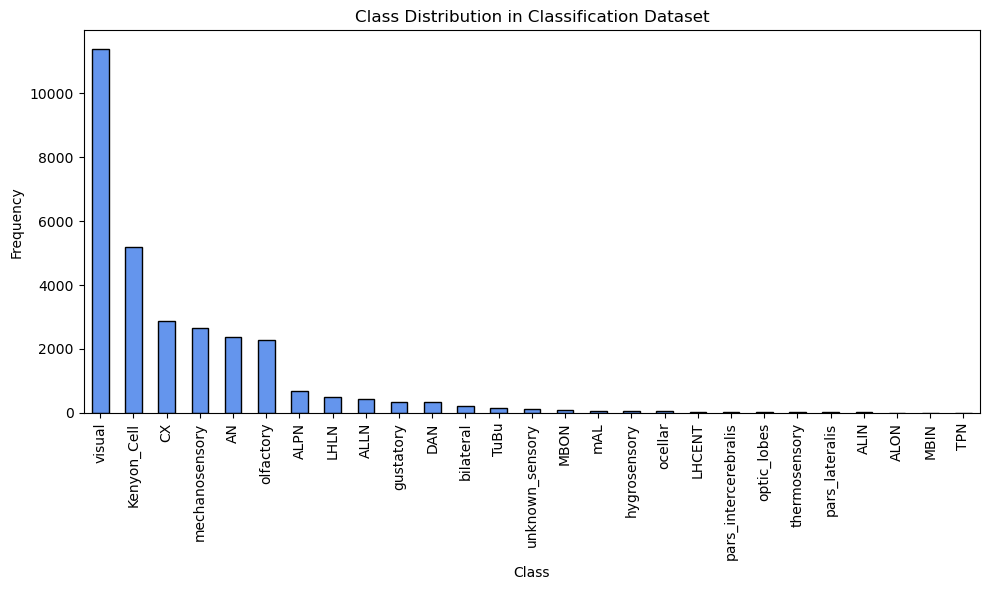

In [5]:
print("Head of the Classification dataset:")
print(labels_df.head())

print("\nShape of classification dataset:", labels_df.shape)
print("Unique class count:", labels_df['class'].nunique())
print("\nClass Distribution:")
print(labels_df['class'].value_counts())

# Plot the class distribution as a bar chart
plt.figure(figsize=(10, 6))
labels_df['class'].value_counts().plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Class Distribution in Classification Dataset")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Preprocessing Data

## Constructing Node Features

### Connectivity

In [6]:
# Create a mapping from root_id to a unique index
node_ids = pd.concat([connections['pre_root_id'], connections['post_root_id']]).unique()
node2idx = {node: i for i, node in enumerate(node_ids)}

In [7]:
# For a manageable baseline, we initially select a subset of nodes (e.g., first 5000)
subset_size = 50000
subset_nodes = set(node_ids[:subset_size])

# Filter connections: keep only edges where both nodes are in the subset
connections_sub = connections[
    connections['pre_root_id'].isin(subset_nodes) & connections['post_root_id'].isin(subset_nodes)
]

In [8]:
# Build edge index for PyTorch Geometric: two rows, one for source nodes, one for target nodes
edge_index = torch.tensor([
    [node2idx[node] for node in connections_sub['pre_root_id']],
    [node2idx[node] for node in connections_sub['post_root_id']]
], dtype=torch.long)

print(edge_index)

tensor([[    0,     1,     2,  ..., 39516,   734, 16180],
        [  457, 39683,  4173,  ..., 21634, 43873, 13644]])


### Cell Size

In [9]:
# Create node features from cell size measurements
features = []
for node in node_ids[:subset_size]:
    row = cell_size[cell_size['root_id'] == node]
    if not row.empty:
        # Using cell size features: length, area, and volume (size_nm)
        feat = row[['length_nm', 'area_nm', 'size_nm']].values[0]
    else:
        # If no measurement is available, use zeros
        feat = np.array([0, 0, 0])
    features.append(feat)
x_cell_size = torch.tensor(np.array(features), dtype=torch.float)

print(x_cell_size)

tensor([[3.5835e+06, 7.6436e+09, 6.5386e+11],
        [4.8576e+06, 1.4268e+10, 1.1406e+12],
        [6.9410e+06, 1.3947e+10, 9.5582e+11],
        ...,
        [3.4437e+06, 6.7948e+09, 4.4553e+11],
        [4.8109e+05, 8.7910e+08, 6.5764e+10],
        [7.6938e+05, 1.1479e+09, 6.7137e+10]])


In [10]:
# Normalize cell size features (min-max scaling)
x_cell_size_np = x_cell_size.cpu().numpy()
min_vals = x_cell_size_np.min(axis=0)
max_vals = x_cell_size_np.max(axis=0)
x_cell_size_norm = (x_cell_size_np - min_vals) / (max_vals - min_vals + 1e-10)
x_cell_size = torch.tensor(x_cell_size_norm, dtype=torch.float).to(x_cell_size.device)

print(x_cell_size)

tensor([[0.0345, 0.0296, 0.0398],
        [0.0468, 0.0553, 0.0695],
        [0.0669, 0.0540, 0.0582],
        ...,
        [0.0332, 0.0263, 0.0271],
        [0.0046, 0.0034, 0.0040],
        [0.0074, 0.0044, 0.0041]])


## Consturicting Ground-Truth Labels

### Converting the Labels into Numbers

In [11]:
# Create a label vector for each node using the classification annotations.
# Ensure that each node in node_ids is assigned a label.

# 1. Extract unique classes from the dataset (excluding NaN)
unique_classes = labels_df['super_class'].dropna().unique()

# 2. Create a mapping from class string to integer
class2idx = {cls: i for i, cls in enumerate(unique_classes)}

# 3. Build an integer label vector for each neuron in node_ids
labels = []
for node in node_ids[:subset_size]:
    row = labels_df[labels_df['root_id'] == node]
    if not row.empty:
        cls_value = row['super_class'].values[0]  # The string label, e.g., "visual"
        if pd.notna(cls_value) and cls_value in class2idx:
            label = class2idx[cls_value]   # Map the string label to an int
        else:
            label = -1                     # For unknown or missing classes
    else:
        label = -1                         # If no row found for this neuron
    labels.append(label)

# Convert the label list to a torch tensor of integer IDs
y_int = torch.tensor(labels, dtype=torch.long)

# Create a mask for valid labels (i.e., not -1)
mask = y_int >= 0
reverse_mask = y_int < 0 
print("Integer label tensor:", y_int)
print("Number of missing labels:", reverse_mask.sum().item())

Integer label tensor: tensor([1, 1, 1,  ..., 0, 0, 0])
Number of missing labels: 0


### One-Hot Encoding the Labels

In [12]:
# 4. Convert valid integer labels to one-hot vectors
num_classes = len(class2idx)
y_one_hot = F.one_hot(y_int, num_classes=num_classes).float()
print("One-hot label shape:", y_one_hot.shape)
print("Example one-hot vector:", y_one_hot[0])

One-hot label shape: torch.Size([50000, 9])
Example one-hot vector: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.])


We have 134181 neurons and 9 unique superclasses in total.

### Visualizing the Label Distribution

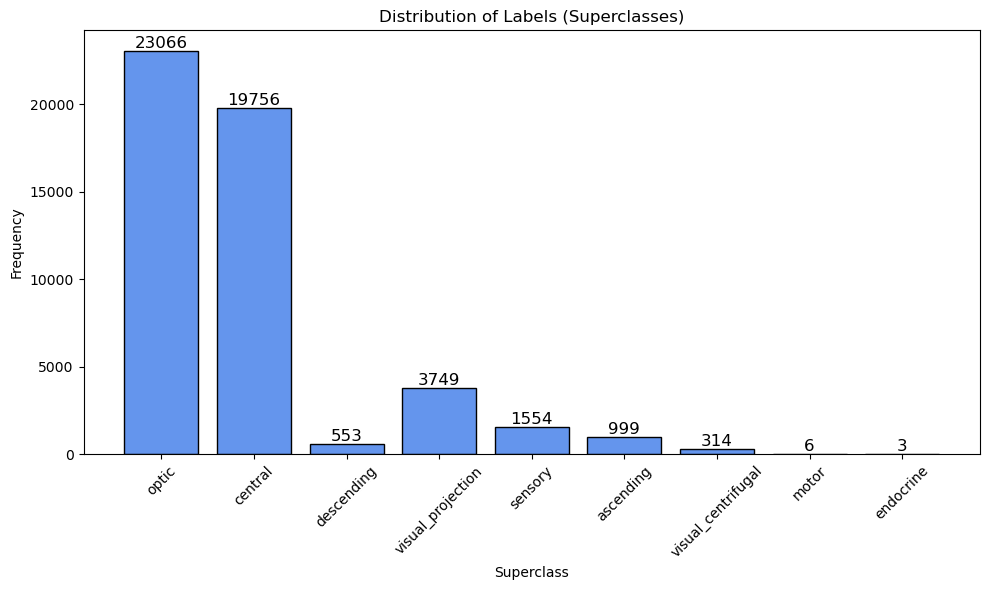

In [13]:
# Get label names back for the valid classes
valid_labels = y_int[mask].numpy()
unique, counts = np.unique(valid_labels, return_counts=True)
idx2class = {v: k for k, v in class2idx.items()}
label_names = [idx2class[i] for i in unique]

# Plot the label distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, counts, color='cornflowerblue', edgecolor='black')
plt.title("Distribution of Labels (Superclasses)")
plt.xlabel("Superclass")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}',
             ha='center', va='bottom', color='black', fontsize=12)

plt.tight_layout()
plt.show()

# Visualizing a (Sub)Graph of our Data

In [14]:
# Convert PyTorch Geometric edge_index to a list of edges
edges = edge_index.t().tolist()

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(len(node_ids)))  # nodes are indexed from 0 to len(node_ids)-1
G.add_edges_from(edges)

/var/folders/pn/y6zh5gpn3rs_kj7p71jpmybh0000gn/T/ipykernel_56082/3449579974.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_valid_classes)


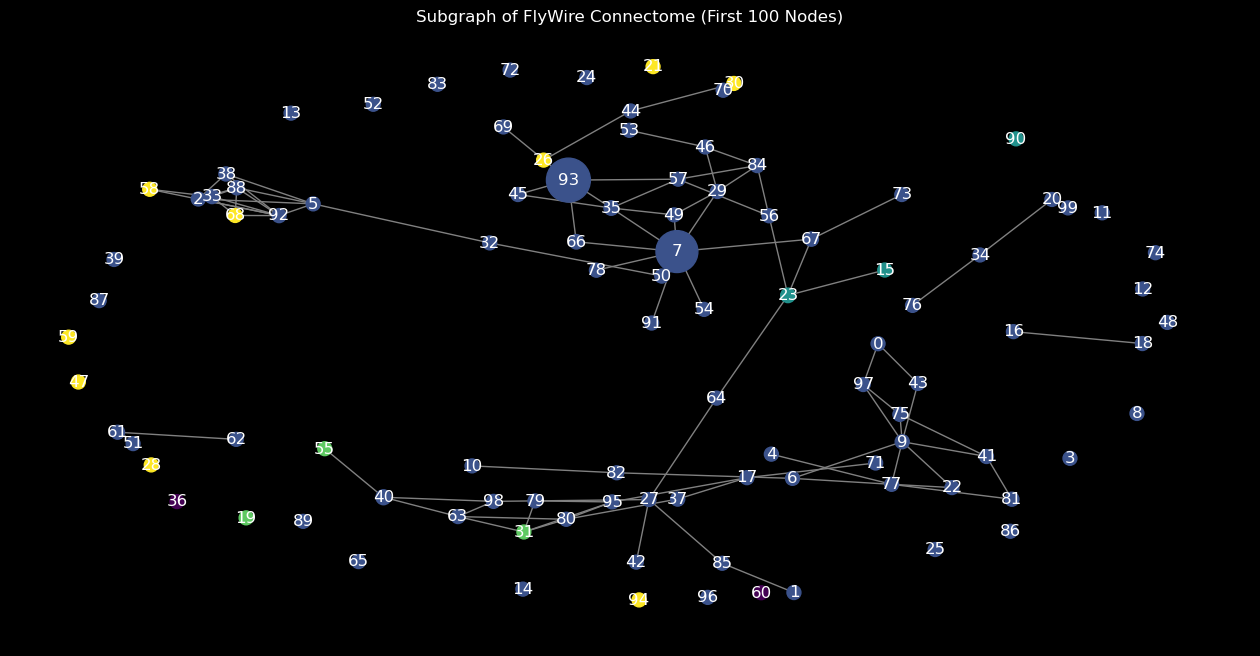

In [15]:
# For visualization, extract a subgraph 
sub_nodes = list(range(100))
subG = nx.Graph()

# Build subgraph from edge_index
# Convert edge_index to list of edges and filter only those edges that connect nodes in sub_nodes
edges = edge_index.t().tolist()
sub_edges = [ (u, v) for u, v in edges if u in sub_nodes and v in sub_nodes ]
subG.add_nodes_from(sub_nodes)
subG.add_edges_from(sub_edges)

# Extract node sizes using the third column ("size_nm") from x for the selected nodes.
sub_features = x_cell_size[sub_nodes].numpy()
# We'll use the third feature as the cell size.
raw_sizes = sub_features[:, 2]

# Normalize sizes to a range that works well for visualization (e.g., between 100 and 1000)
min_size, max_size = raw_sizes.min(), raw_sizes.max()
node_sizes = 100 + 900 * ((raw_sizes - min_size) / (max_size - min_size)) ** 3

# Extract labels for the subgraph nodes from y_int
sub_labels = y_int[sub_nodes].numpy()

# Create a colormap for valid labels. We'll use 'viridis' and assign a default gray for missing labels (-1).
unique_valid_labels = [lbl for lbl in sub_labels if lbl >= 0]
num_valid_classes = len(set(unique_valid_labels)) if unique_valid_labels else 1
cmap = plt.cm.get_cmap('viridis', num_valid_classes)

# Map each node's label to a color.
node_colors = []
for lbl in sub_labels:
    if lbl < 0:
        node_colors.append('#808080')  # gray for missing/invalid labels
    else:
        # Normalize label index to colormap range
        node_colors.append(cmap(lbl % num_valid_classes))

# Generate a layout with increased separation
pos = nx.spring_layout(subG, seed=6, k=0.5, iterations=100)

# Create the plot with a black background
plt.figure(figsize=(16, 8), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

nx.draw_networkx(
    subG, 
    pos=pos, 
    with_labels=True, 
    node_color=node_colors, 
    edge_color='gray', 
    node_size=node_sizes,
    font_color='white'
)

plt.title("Subgraph of FlyWire Connectome (First 100 Nodes)", color='white')
plt.axis('off')
plt.show()

# Forming Datasets

## Constructing the PyTorch Geometric data objects

In [16]:
# We use a constant vector with value 1 for our baseline model
x_plain = torch.ones((subset_size, 1), dtype=torch.float)
print(x_plain)

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])


In [17]:
# We constructed x_cell_size before but we will not use it for our baseline model
print(x_cell_size)

tensor([[0.0345, 0.0296, 0.0398],
        [0.0468, 0.0553, 0.0695],
        [0.0669, 0.0540, 0.0582],
        ...,
        [0.0332, 0.0263, 0.0271],
        [0.0046, 0.0034, 0.0040],
        [0.0074, 0.0044, 0.0041]])


In [18]:
# Create the PyTorch Geometric data object
data_plain = Data(x=x_plain, edge_index=edge_index, y=y_int)

In [19]:
data_cell_size = Data(x=x_cell_size, edge_index=edge_index, y=y_int)

## Train-Test Split

In [20]:
# For training, use only the nodes with valid labels.
valid_idx = torch.nonzero(mask).view(-1)

# Determine number of classes (will be useful when we are defining the models)
num_classes = len(unique_classes)

# Split valid nodes into train and test sets (e.g., 70/30 split)
train_idx_np, test_idx_np = train_test_split(valid_idx.numpy(), test_size=0.3, random_state=6, stratify=y_int[mask].numpy())
train_idx = torch.tensor(train_idx_np, dtype=torch.long)
test_idx = torch.tensor(test_idx_np, dtype=torch.long)

## Inverse Class Weights

In [21]:
# Compute class frequencies from the valid training nodes only
valid_labels = y_int[mask].numpy()
classes, counts = np.unique(valid_labels, return_counts=True)
class_weights = np.zeros(num_classes)
for c, cnt in zip(classes, counts):
    class_weights[c] = 1.0 / cnt  # Inverse frequency

# Convert class weights to a torch tensor and normalize them
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # Normalization, though not necessary

print("Class weights:", class_weights)

Class weights: tensor([8.5511e-05, 9.9838e-05, 3.5667e-03, 5.2611e-04, 1.2692e-03, 1.9744e-03,
        6.2815e-03, 3.2873e-01, 6.5746e-01])


# Models

In [22]:
class BaselineGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(BaselineGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5) # for regularization
        x = self.conv2(x, edge_index)
        return x
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)

In [23]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5)
        # Second layer: output logits for each class
        x = self.conv2(x, edge_index)
        return x
sage_model = GraphSAGE(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)

# Helper Train and Test functions

In [24]:
def get_optimizer(model, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return optimizer

def train(model, data, optimizer, criterion, train_idx):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data, optimizer, criterion):
    # Get the ground truths vs the model predictions
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()

    # Compute evaluation metrics: loss, accuracy, f1 score, per class accuracy
    test_loss = criterion(out[test_idx], data.y[test_idx]).item()
    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='macro')

    # Compute per class accuracy
    test_per_class_acc = []
    for i in range(num_classes):
        idx = np.where(y_true == i)[0]
        if len(idx) > 0:
            acc = np.mean(y_pred[idx] == y_true[idx])
        else:
            acc = np.nan  # No samples for this class in the test set
        test_per_class_acc.append(acc)
    
    return test_loss, test_acc, test_f1, test_per_class_acc

In [25]:
def plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s):  
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(epochs_recorded, test_losses, marker='o', color='tab:blue')
    axs[0].set_title("Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    
    axs[1].plot(epochs_recorded, test_accuracies, marker='o', color='tab:green')
    axs[1].set_title("Test Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    
    axs[2].plot(epochs_recorded, test_f1s, marker='o', color='tab:red')
    axs[2].set_title("Test F1 Score")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("F1 Score")
    
    plt.tight_layout()
    plt.show()

In [26]:
def plot_experiment_results_per_class(epochs_recorded, per_class_acc_history):  
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(num_classes):
        ax.plot(epochs_recorded, per_class_acc_history[:, i], marker='o', label=f'Class {i}')
    ax.set_title("Per-Category Accuracy over Time")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    plt.show()

In [32]:
def f1_per_class(model, data, optimizer, criterion):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = pred[test_idx].cpu().numpy()
    
    f1_per_class = f1_score(y_true, y_pred, average=None)
    return f1_per_class

In [33]:
def plot_f1_per_class(epochs_recorded, f1_per_class_history):  
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(num_classes):
        ax.plot(epochs_recorded, f1_per_class_history[:, i], marker='o', label=f'Class {i}')
    ax.set_title("Per-Category F1 Score over Time")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1 Score")
    ax.legend()
    plt.show()

# Data Imbalance Techniques

## GraphME

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ME(nn.Module):
    def __init__(self, device, balancing_factor=0.3):
        super(ME, self).__init__()
        self.nll_loss = nn.NLLLoss()
        self.device = device  # Example: 'cuda:0' or 'cpu'
        self.balancing_factor = balancing_factor

    def forward(self, yHat, y, weight=None):
        # yHat is the raw output (logits) from the model.
        # y are the true labels.
        batch_size = len(y)
        
        # Compute the standard cross-entropy loss via negative log likelihood of log_softmax outputs.
        cross_entropy = self.nll_loss(F.log_softmax(yHat, dim=1), y)
        
        # Compute the prediction entropy regularization.
        yHat_soft = F.softmax(yHat, dim=1)
        Px = yHat_soft
        Px_log = torch.log(Px + 1e-10)
        # Sum over samples and classes, then average over the batch
        regularization_entropy = torch.sum(Px * Px_log.to(self.device)) / (float(batch_size) * yHat.shape[1])
        
        # Return the mixed entropy loss: cross_entropy minus balancing_factor * regularization_entropy
        return cross_entropy - self.balancing_factor * regularization_entropy

## GraphSmote

In [28]:
def smote_oversample(
    edge_index, 
    features, 
    labels, 
    train_idx, 
    portion=1.0, 
    minority_classes=[...]
):
    """
    Oversample minority classes in the raw feature space using a SMOTE-like approach.
    
    For each training node in the specified minority classes, generate multiple (replication_factor)
    synthetic samples by interpolating between the node's features and its nearest neighbor's features.
    Also, update the adjacency matrix by replicating the connectivity rows accordingly.
    
    :param edge_index: (2, E) PyTorch tensor of edges
    :param features: (N, F) raw feature tensor
    :param labels: (N,) integer label tensor
    :param train_idx: (T,) indices of training nodes
    :param portion: replication factor (number of synthetic samples to generate per node)
    :param minority_classes: list of class IDs to oversample
    :return: updated (edge_index, features, labels, train_idx)
    """
    # 1. Convert edge_index to dense adjacency for easy manipulation:
    N = features.shape[0]
    dense_adj = torch.zeros(N, N, dtype=torch.float)
    for (src, dst) in edge_index.t().tolist():
        dense_adj[src, dst] = 1.
        dense_adj[dst, src] = 1.  # undirected graph

    new_features_list = []
    new_labels_list = []
    new_rows_adj = []  # Will store new adjacency rows (for synthetic nodes)
    new_indices_train = []

    current_N = N  # Current number of nodes; will be updated after synthetic nodes are added

    # Loop over each minority class
    for c in minority_classes:
        # 2. Get training nodes for class c
        class_mask = (labels == c)
        # Use boolean indexing on train_idx: train_idx[class_mask[train_idx]]
        chosen_idx = train_idx[class_mask[train_idx]]
        
        if chosen_idx.shape[0] == 0:
            continue  # skip if no training node for this minority class
        
        replication_factor = int(portion)  # number of synthetic samples to generate per node
        
        # Extract features for the selected nodes
        chosen_embed = features[chosen_idx]  # shape: (M, F)
        M, F = chosen_embed.shape

        # Compute pairwise distances among these nodes (using their features)
        distance = squareform(pdist(chosen_embed.cpu().numpy()))
        np.fill_diagonal(distance, 1e7)  # Ensure a node is not its own neighbor

        # Find the nearest neighbor for each node
        idx_neighbor = distance.argmin(axis=-1)  # length M

        synthetic_samples = []
        # For each minority node, generate replication_factor synthetic samples
        for i in range(M):
            for rep in range(replication_factor):
                alpha = random.random()  # random interpolation coefficient in (0,1)
                # Linear interpolation between sample and its nearest neighbor
                synthetic_sample = chosen_embed[i] + alpha * (chosen_embed[idx_neighbor[i]] - chosen_embed[i])
                synthetic_samples.append(synthetic_sample.unsqueeze(0))  # keep batch dimension

        # Concatenate synthetic samples; shape will be (M * replication_factor, F)
        synthetic_embeds = torch.cat(synthetic_samples, dim=0)
        replicate_count = synthetic_embeds.shape[0]

        # Save synthetic features and labels
        new_features_list.append(synthetic_embeds)
        new_labels_list.append(torch.full((replicate_count,), c, dtype=torch.long))
        new_indices_train.append(torch.arange(current_N, current_N + replicate_count, dtype=torch.long))
        
        # Also, compute new adjacency rows:
        # For each selected original node, compute an adjacency row by averaging its row with that of its nearest neighbor.
        base_new_rows = (dense_adj[chosen_idx] + dense_adj[chosen_idx[idx_neighbor]]).clamp_(0, 1)  # shape: (M, N)
        # Replicate each row replication_factor times.
        repeated_new_rows = base_new_rows.repeat_interleave(replication_factor, dim=0)  # shape: (M*replication_factor, N)
        new_rows_adj.append(repeated_new_rows)
        
        current_N += replicate_count  # update current node count

    # If no synthetic samples were generated, return the original data
    if len(new_features_list) == 0:
        print("No minority classes found for SMOTE oversampling.")
        return edge_index, features, labels, train_idx

    # 5. Concatenate synthetic data with original data
    new_features = torch.cat(new_features_list, dim=0)
    new_labels = torch.cat(new_labels_list, dim=0)
    new_train_indices = torch.cat(new_indices_train, dim=0)

    updated_features = torch.cat([features, new_features], dim=0)
    updated_labels = torch.cat([labels, new_labels], dim=0)
    updated_train_idx = torch.cat([train_idx, new_train_indices], dim=0)

    # 6. Build updated dense adjacency matrix
    added_size = new_features.shape[0]
    old_size = features.shape[0]
    updated_dense_adj = torch.zeros(old_size + added_size, old_size + added_size)
    
    # Place the original dense adjacency matrix in the top-left block
    updated_dense_adj[:old_size, :old_size] = dense_adj

    offset = 0
    # For each minority class (in the order they were processed)
    for i in range(len(new_rows_adj)):
        replicate_count = new_rows_adj[i].shape[0]
        # Place the new adjacency rows in the lower-left block
        updated_dense_adj[old_size+offset : old_size+offset+replicate_count, :old_size] = new_rows_adj[i]
        # Set the symmetric block for an undirected graph
        updated_dense_adj[:old_size, old_size+offset : old_size+offset+replicate_count] = new_rows_adj[i].T
        offset += replicate_count

    # Optionally, we can set connections among synthetic nodes, e.g.:
    # updated_dense_adj[old_size:, old_size:] = some value or the identity matrix
    # For now we leave it as zeros (in the future we could copy from original nodes)

    # Convert updated dense adjacency back to edge_index format
    new_edge_index = (updated_dense_adj > 0).nonzero(as_tuple=False).T

    return new_edge_index, updated_features, updated_labels, updated_train_idx


In [ ]:
minority_classes = [2, 3, 4, 5, 6, 7, 8]
new_edge_index, new_features, new_labels, train_idx_smote = smote_oversample(
    edge_index, 
    torch.ones((subset_size, 1), dtype=torch.float) + 0.01 * torch.randn((subset_size, 1)), 
    y_int, 
    train_idx, 
    portion=6.0,
    minority_classes=minority_classes
)

data_smote = Data(x=new_features, edge_index=new_edge_index, y=new_labels)

In [ ]:
data_smote

In [29]:
minority_classes = [3, 4]
new_edge_index, new_features, new_labels, train_idx_smote_cell_size = smote_oversample(
    edge_index, 
    x_cell_size, 
    y_int, 
    train_idx, 
    portion=6.0,
    minority_classes=minority_classes
)

data_smote_cell_size = Data(x=new_features, edge_index=new_edge_index, y=new_labels)

In [30]:
data_smote_cell_size

Data(x=[72278, 3], edge_index=[2, 5704122], y=[72278])

In [1]:
print("hello")

hello


In [ ]:
# Compute unique classes and their counts in data_smote
labels_smote = data_smote.y.cpu().numpy()
unique_classes, counts = np.unique(labels_smote, return_counts=True)

# Plot the label distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, counts, color='cornflowerblue', edgecolor='black')
plt.title("Distribution of Labels (Superclasses) in Data_SMOTE")
plt.xlabel("Superclass")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}',
             ha='center', va='bottom', color='black', fontsize=12)

plt.tight_layout()
plt.show()

# Experiments

## Baseline GCN Model, Connectivity Data

Epoch 020: Loss=1.5381, Test Loss=1.4921, Accuracy=0.4613, F1=0.0702
Epoch 040: Loss=1.3272, Test Loss=1.3049, Accuracy=0.3937, F1=0.0628
Epoch 060: Loss=1.2933, Test Loss=1.2691, Accuracy=0.5705, F1=0.1366
Epoch 080: Loss=1.2655, Test Loss=1.2416, Accuracy=0.5951, F1=0.1399
Epoch 100: Loss=1.2577, Test Loss=1.2178, Accuracy=0.5999, F1=0.1418
Epoch 120: Loss=1.2241, Test Loss=1.1966, Accuracy=0.6009, F1=0.1425
Epoch 140: Loss=1.2010, Test Loss=1.1721, Accuracy=0.6014, F1=0.1426
Epoch 160: Loss=1.1686, Test Loss=1.1560, Accuracy=0.6031, F1=0.1428
Epoch 180: Loss=1.1697, Test Loss=1.1450, Accuracy=0.6031, F1=0.1432
Epoch 200: Loss=1.1636, Test Loss=1.1339, Accuracy=0.6029, F1=0.1430
Epoch 220: Loss=1.1427, Test Loss=1.1258, Accuracy=0.6018, F1=0.1429
Epoch 240: Loss=1.1571, Test Loss=1.1196, Accuracy=0.6029, F1=0.1426
Epoch 260: Loss=1.1407, Test Loss=1.1134, Accuracy=0.6034, F1=0.1427
Epoch 280: Loss=1.1344, Test Loss=1.1082, Accuracy=0.6028, F1=0.1428
Epoch 300: Loss=1.1334, Test Loss=

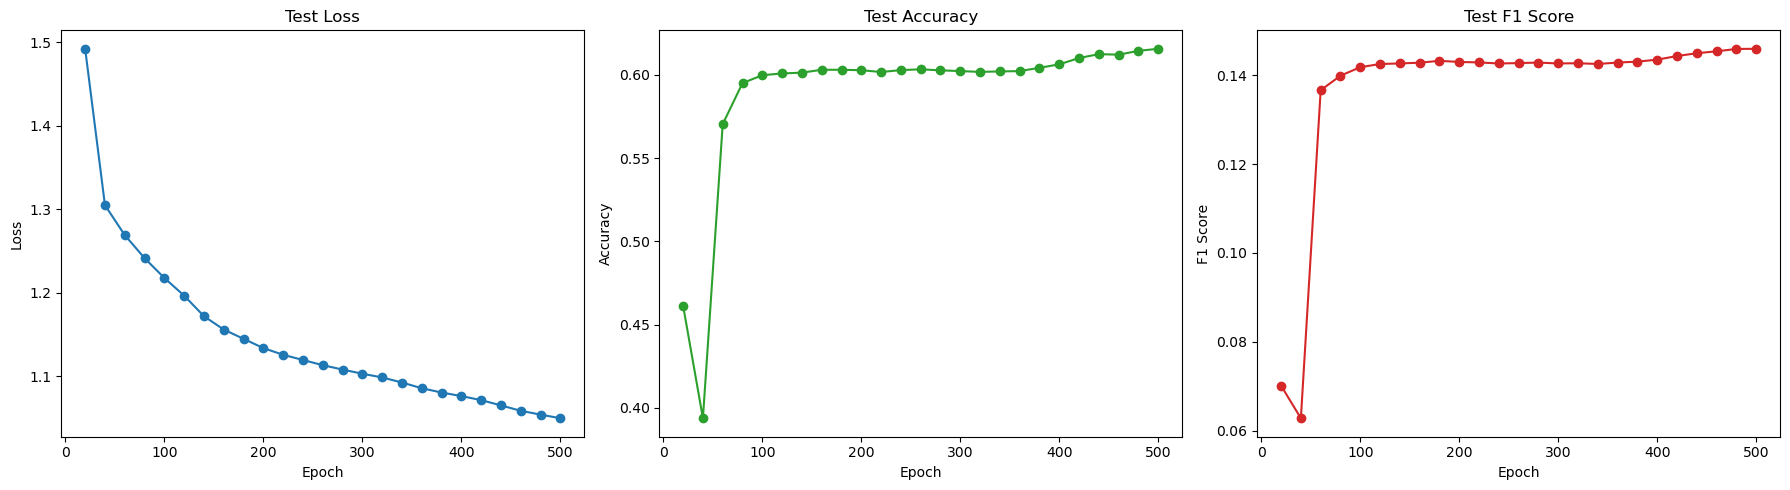

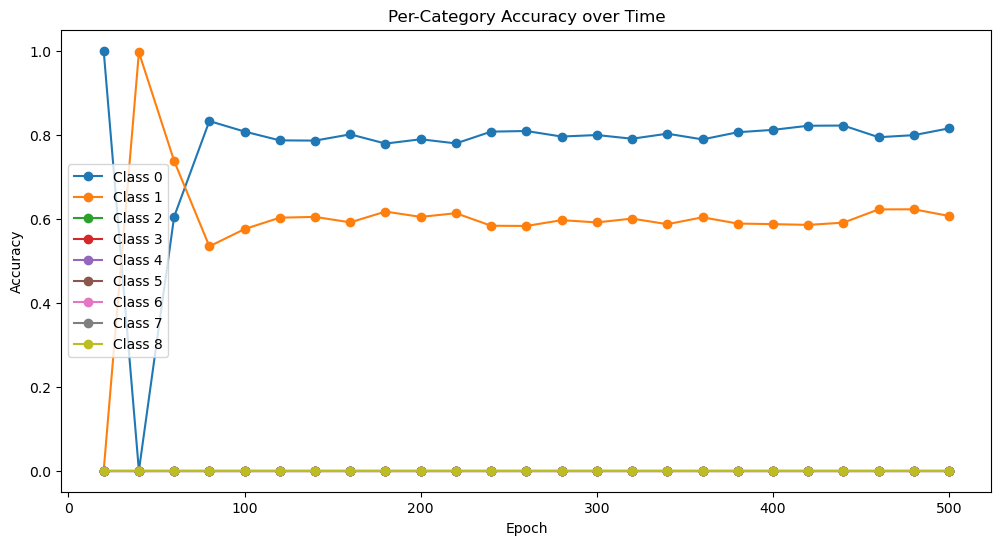

In [35]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)
model = baseline_gcn
data = data_plain
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))

## Baseline GCN Model, Connectivity Data, Class Weights

Epoch 020: Loss=2.1501, Test Loss=2.1525, Accuracy=0.0619, F1=0.0254
Epoch 040: Loss=2.0935, Test Loss=2.1280, Accuracy=0.0372, F1=0.0150
Epoch 060: Loss=2.0627, Test Loss=2.0948, Accuracy=0.0763, F1=0.0464
Epoch 080: Loss=2.0132, Test Loss=2.0707, Accuracy=0.2223, F1=0.1052
Epoch 100: Loss=1.9947, Test Loss=2.0506, Accuracy=0.3373, F1=0.1320
Epoch 120: Loss=2.0071, Test Loss=2.0147, Accuracy=0.3445, F1=0.1312
Epoch 140: Loss=1.9673, Test Loss=1.9950, Accuracy=0.3257, F1=0.1290
Epoch 160: Loss=1.9295, Test Loss=1.9736, Accuracy=0.3334, F1=0.1344
Epoch 180: Loss=2.0012, Test Loss=1.9626, Accuracy=0.2240, F1=0.1094
Epoch 200: Loss=1.9629, Test Loss=1.9621, Accuracy=0.3959, F1=0.1506
Epoch 220: Loss=1.9162, Test Loss=1.9464, Accuracy=0.3043, F1=0.1565
Epoch 240: Loss=1.9101, Test Loss=1.9356, Accuracy=0.2849, F1=0.1500
Epoch 260: Loss=1.9731, Test Loss=1.9301, Accuracy=0.2446, F1=0.1400
Epoch 280: Loss=1.9307, Test Loss=1.9200, Accuracy=0.2534, F1=0.1465
Epoch 300: Loss=1.9288, Test Loss=

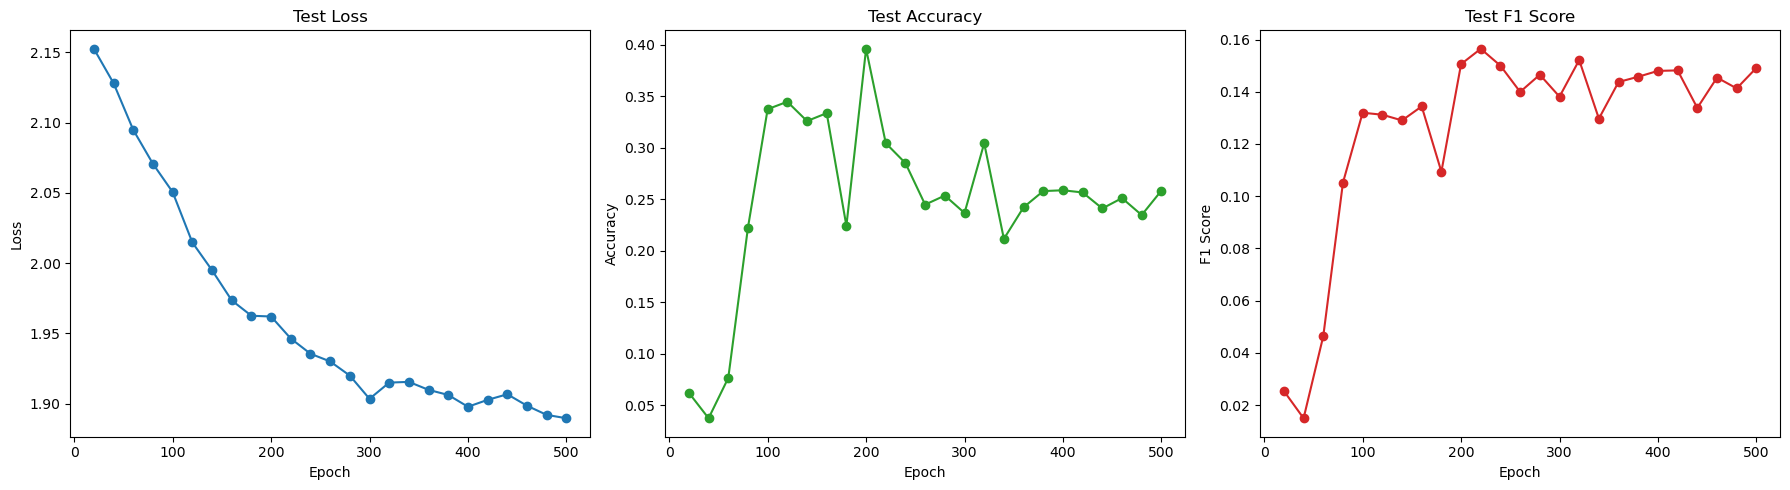

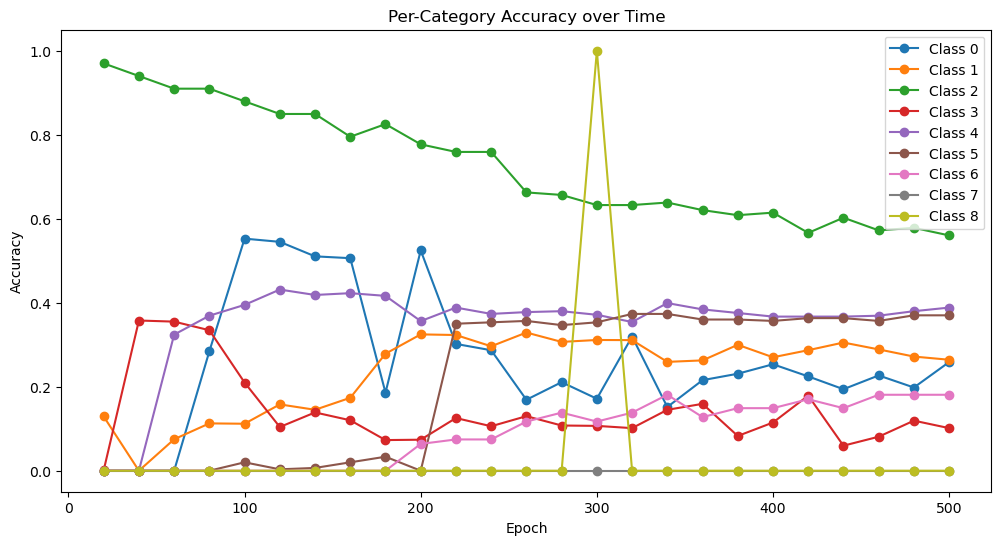

In [54]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)
model = baseline_gcn
data = data_plain
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss(weight=class_weights)
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))

# Baseline GCN Model, Connectivity Data, ME Loss

Epoch 020: Loss=1.6344, Test Loss=1.5840, Accuracy=0.3951, F1=0.0629
Epoch 040: Loss=1.3601, Test Loss=1.3400, Accuracy=0.5689, F1=0.1362
Epoch 060: Loss=1.3247, Test Loss=1.2954, Accuracy=0.5810, F1=0.1388
Epoch 080: Loss=1.2895, Test Loss=1.2473, Accuracy=0.5871, F1=0.1400
Epoch 100: Loss=1.2424, Test Loss=1.2134, Accuracy=0.5865, F1=0.1398
Epoch 120: Loss=1.2241, Test Loss=1.1990, Accuracy=0.5878, F1=0.1403
Epoch 140: Loss=1.2010, Test Loss=1.1861, Accuracy=0.5927, F1=0.1409
Epoch 160: Loss=1.1978, Test Loss=1.1723, Accuracy=0.5938, F1=0.1412
Epoch 180: Loss=1.1682, Test Loss=1.1602, Accuracy=0.5939, F1=0.1411
Epoch 200: Loss=1.1868, Test Loss=1.1484, Accuracy=0.5949, F1=0.1415
Epoch 220: Loss=1.1556, Test Loss=1.1384, Accuracy=0.5963, F1=0.1417
Epoch 240: Loss=1.1693, Test Loss=1.1329, Accuracy=0.5966, F1=0.1414
Epoch 260: Loss=1.1437, Test Loss=1.1283, Accuracy=0.5968, F1=0.1417
Epoch 280: Loss=1.1787, Test Loss=1.1245, Accuracy=0.5973, F1=0.1421
Epoch 300: Loss=1.1357, Test Loss=

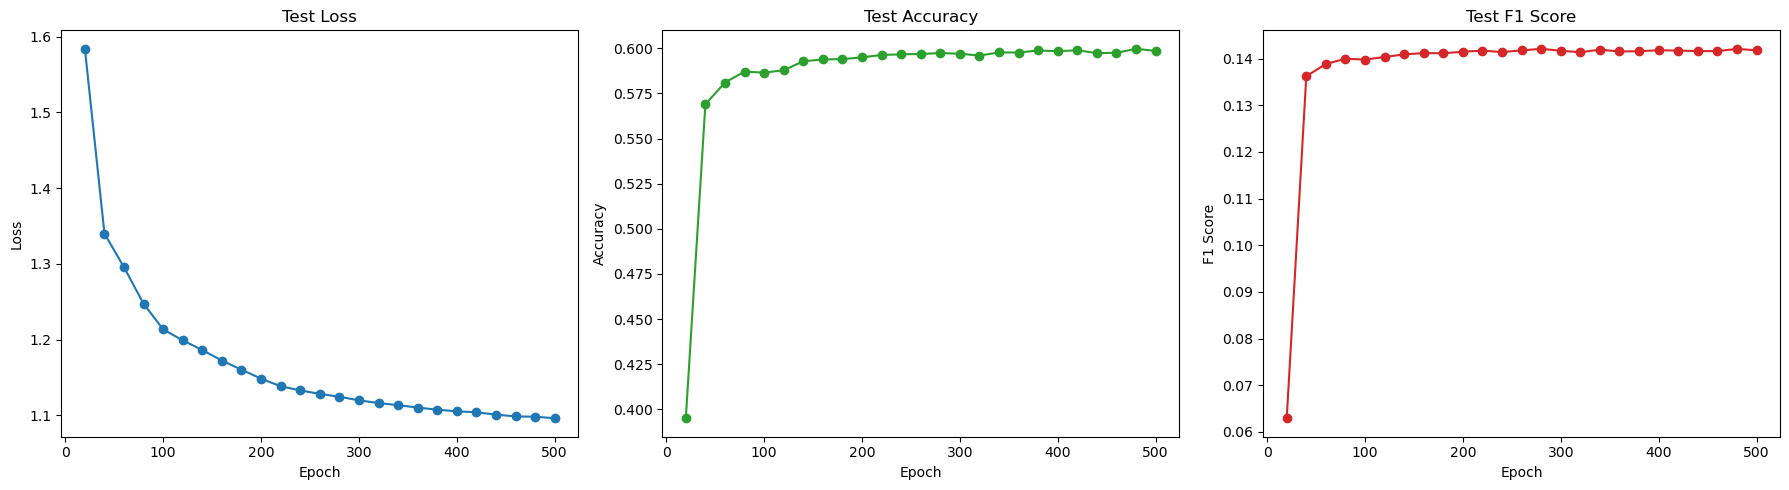

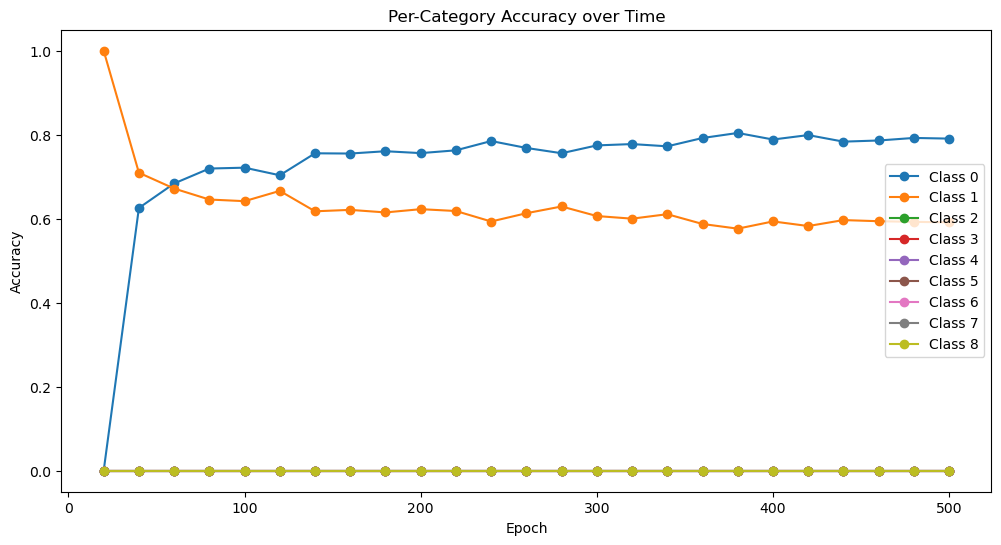

In [55]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_plain.x.shape[1], hidden_channels=16, num_classes=num_classes)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = baseline_gcn.to(device)
data = data_plain.to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = ME(device=device, balancing_factor=0.3)
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))

In [56]:
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

Class 0, final accuracy: 0.7907514450867053
Class 1, final accuracy: 0.5913615657162139
Class 2, final accuracy: 0.0
Class 3, final accuracy: 0.0
Class 4, final accuracy: 0.0
Class 5, final accuracy: 0.0
Class 6, final accuracy: 0.0
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


# Baseline GCN Model, SMOTE'd Connectivity Data

Epoch 020: Loss=1.8583, Test Loss=1.6730, Accuracy=0.4585, F1=0.0799
Epoch 040: Loss=1.7470, Test Loss=1.5923, Accuracy=0.1040, F1=0.0310
Epoch 060: Loss=1.7007, Test Loss=1.5750, Accuracy=0.1727, F1=0.0605
Epoch 080: Loss=1.6184, Test Loss=1.5380, Accuracy=0.3576, F1=0.1183
Epoch 100: Loss=1.5494, Test Loss=1.5206, Accuracy=0.4118, F1=0.1334
Epoch 120: Loss=1.5087, Test Loss=1.5024, Accuracy=0.4219, F1=0.1426
Epoch 140: Loss=1.4780, Test Loss=1.4876, Accuracy=0.4215, F1=0.1413
Epoch 160: Loss=1.4719, Test Loss=1.4606, Accuracy=0.4275, F1=0.1406
Epoch 180: Loss=1.4540, Test Loss=1.4429, Accuracy=0.4327, F1=0.1410
Epoch 200: Loss=1.4424, Test Loss=1.4294, Accuracy=0.4407, F1=0.1439
Epoch 220: Loss=1.4429, Test Loss=1.4166, Accuracy=0.4401, F1=0.1441
Epoch 240: Loss=1.4270, Test Loss=1.4099, Accuracy=0.4419, F1=0.1457
Epoch 260: Loss=1.4312, Test Loss=1.4059, Accuracy=0.4437, F1=0.1455
Epoch 280: Loss=1.4078, Test Loss=1.3966, Accuracy=0.4443, F1=0.1448
Epoch 300: Loss=1.4196, Test Loss=

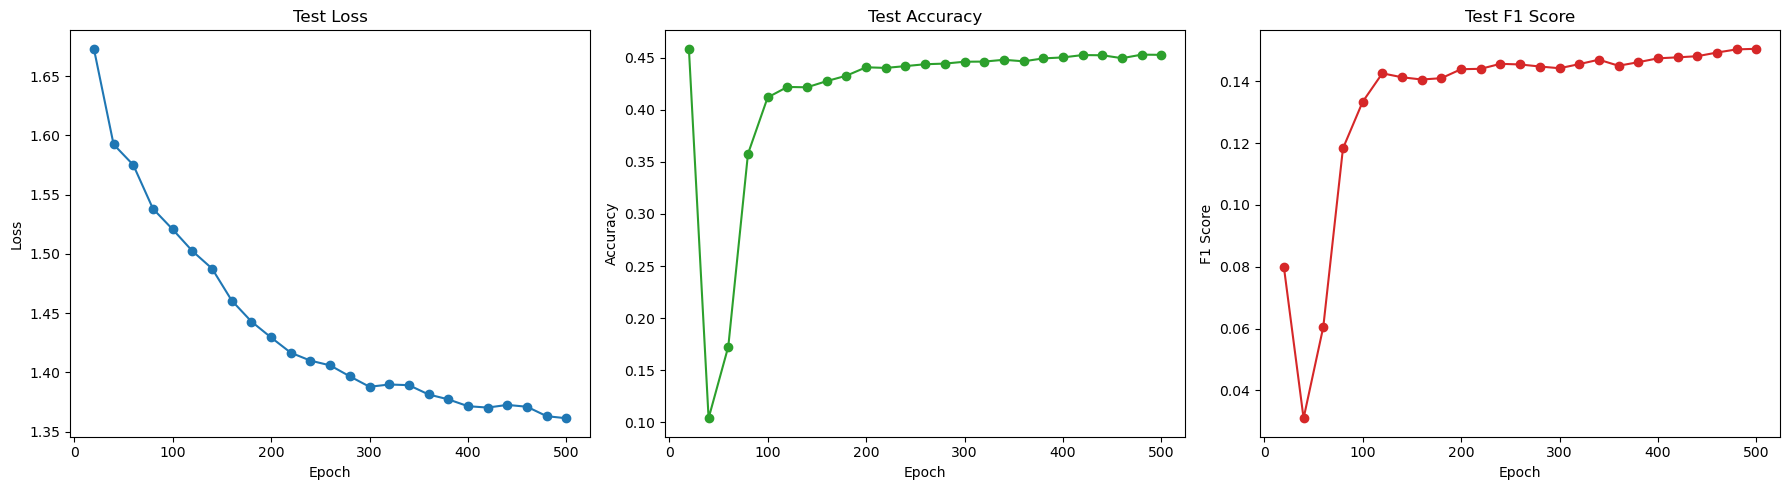

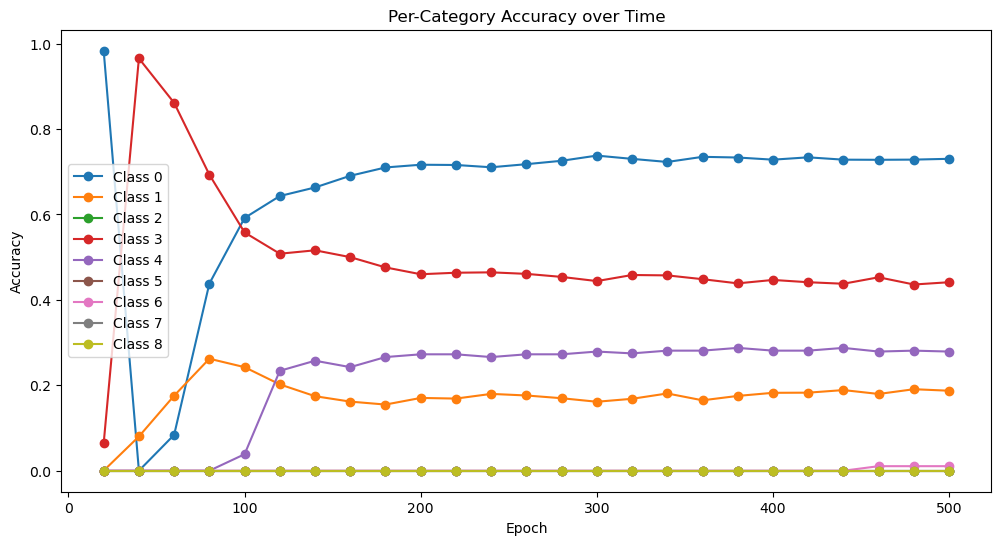

Class 0, final accuracy: 0.7302023121387283
Class 1, final accuracy: 0.1872785557617682
Class 2, final accuracy: 0.0
Class 3, final accuracy: 0.4412811387900356
Class 4, final accuracy: 0.27896995708154504
Class 5, final accuracy: 0.0
Class 6, final accuracy: 0.010638297872340425
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


In [31]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_smote.x.shape[1], hidden_channels=16, num_classes=num_classes)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = baseline_gcn.to(device)
data = data_smote.to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx_smote)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

# Baseline GCN Model, SMOTE'd Connectivity Data, ME Loss

Epoch 020: Loss=1.9006, Test Loss=1.6783, Accuracy=0.0756, F1=0.0159
Epoch 040: Loss=1.7900, Test Loss=1.6263, Accuracy=0.1813, F1=0.0650
Epoch 060: Loss=1.7064, Test Loss=1.5867, Accuracy=0.3211, F1=0.1089
Epoch 080: Loss=1.6385, Test Loss=1.5620, Accuracy=0.3885, F1=0.1190
Epoch 100: Loss=1.5962, Test Loss=1.5531, Accuracy=0.4095, F1=0.1376
Epoch 120: Loss=1.5508, Test Loss=1.5385, Accuracy=0.4196, F1=0.1408
Epoch 140: Loss=1.5076, Test Loss=1.5152, Accuracy=0.4280, F1=0.1438
Epoch 160: Loss=1.4952, Test Loss=1.4884, Accuracy=0.4316, F1=0.1439
Epoch 180: Loss=1.4743, Test Loss=1.4723, Accuracy=0.4312, F1=0.1405
Epoch 200: Loss=1.4732, Test Loss=1.4654, Accuracy=0.4377, F1=0.1445
Epoch 220: Loss=1.4614, Test Loss=1.4475, Accuracy=0.4393, F1=0.1451
Epoch 240: Loss=1.4502, Test Loss=1.4387, Accuracy=0.4418, F1=0.1452
Epoch 260: Loss=1.4385, Test Loss=1.4426, Accuracy=0.4396, F1=0.1444
Epoch 280: Loss=1.4206, Test Loss=1.4172, Accuracy=0.4497, F1=0.1486
Epoch 300: Loss=1.4293, Test Loss=

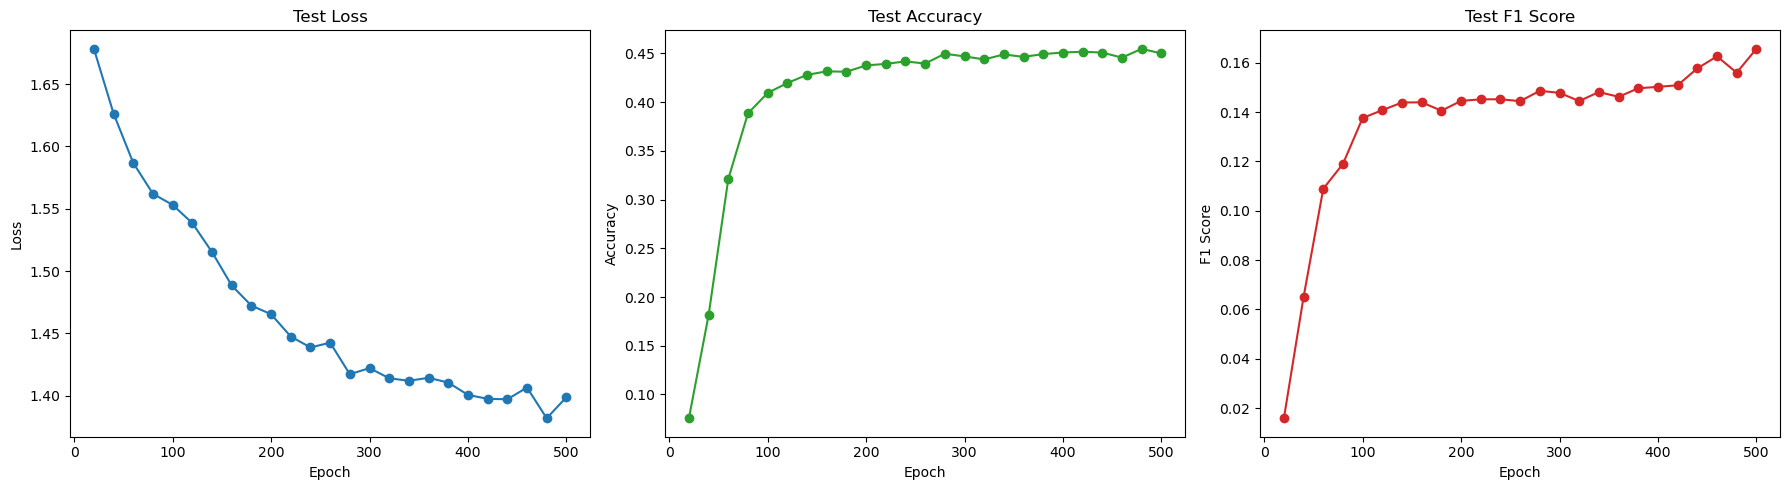

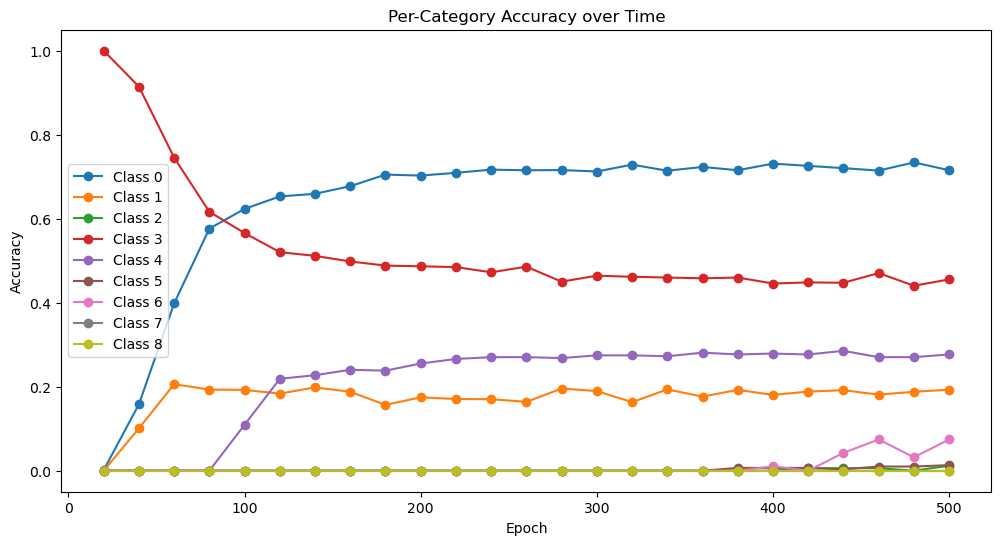

Class 0, final accuracy: 0.7154624277456647
Class 1, final accuracy: 0.19301501602834487
Class 2, final accuracy: 0.012048192771084338
Class 3, final accuracy: 0.4555160142348754
Class 4, final accuracy: 0.27682403433476394
Class 5, final accuracy: 0.013333333333333334
Class 6, final accuracy: 0.07446808510638298
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


In [30]:
# Setting up the model, data, and the hyperparameters
baseline_gcn = BaselineGCN(in_channels=data_smote.x.shape[1], hidden_channels=16, num_classes=num_classes)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = baseline_gcn.to(device)
data = data_smote.to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = ME(device=device, balancing_factor=0.3)
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx_smote)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

# GCN Model, Cell Size + Connectivity Data

Epoch 020: Loss=1.6014, Test Loss=1.5684, Accuracy=0.4613, F1=0.0702
Epoch 040: Loss=1.3322, Test Loss=1.3134, Accuracy=0.6944, F1=0.1663
Epoch 060: Loss=1.2874, Test Loss=1.2683, Accuracy=0.5889, F1=0.1305
Epoch 080: Loss=1.2554, Test Loss=1.2352, Accuracy=0.6349, F1=0.1465
Epoch 100: Loss=1.2254, Test Loss=1.2020, Accuracy=0.6781, F1=0.1598
Epoch 120: Loss=1.1823, Test Loss=1.1570, Accuracy=0.7041, F1=0.1673
Epoch 140: Loss=1.1326, Test Loss=1.1033, Accuracy=0.7585, F1=0.1815
Epoch 160: Loss=1.0773, Test Loss=1.0505, Accuracy=0.7617, F1=0.1823
Epoch 180: Loss=1.0388, Test Loss=1.0100, Accuracy=0.7713, F1=0.1847
Epoch 200: Loss=1.0120, Test Loss=0.9797, Accuracy=0.7733, F1=0.1851
Epoch 220: Loss=0.9911, Test Loss=0.9580, Accuracy=0.7753, F1=0.1856
Epoch 240: Loss=0.9752, Test Loss=0.9408, Accuracy=0.7755, F1=0.1858
Epoch 260: Loss=0.9782, Test Loss=0.9278, Accuracy=0.7757, F1=0.1859
Epoch 280: Loss=0.9472, Test Loss=0.9184, Accuracy=0.7755, F1=0.1859
Epoch 300: Loss=0.9429, Test Loss=

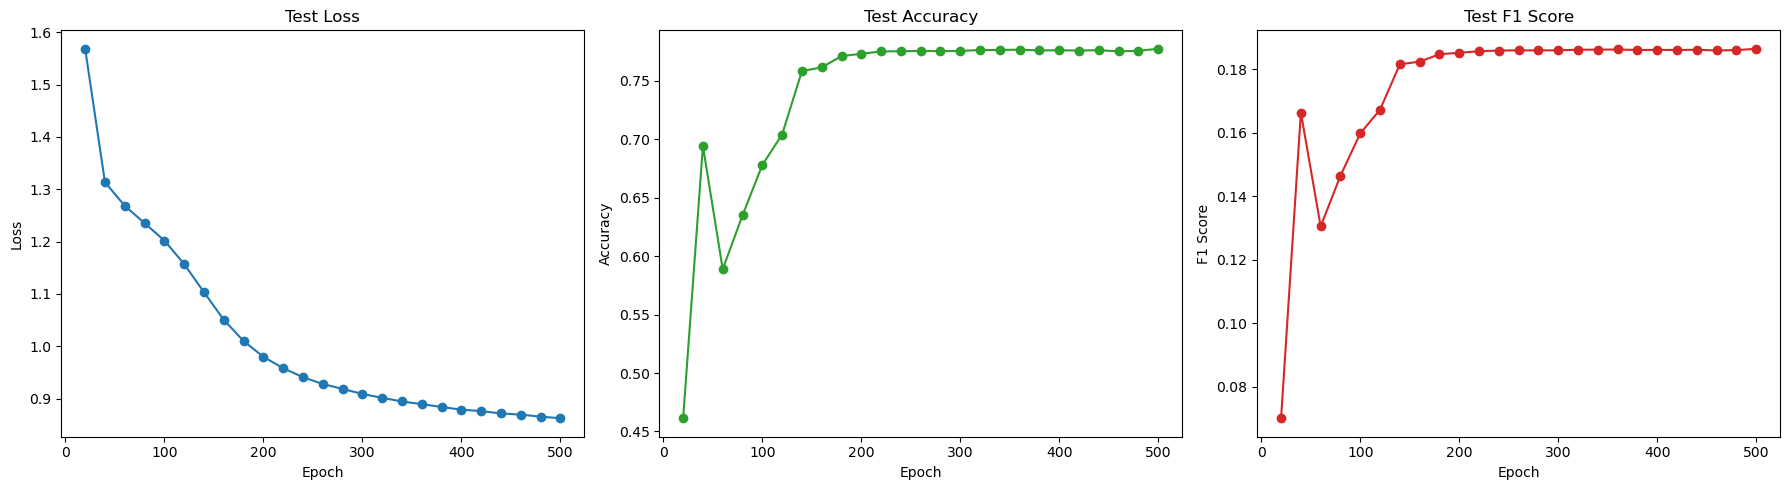

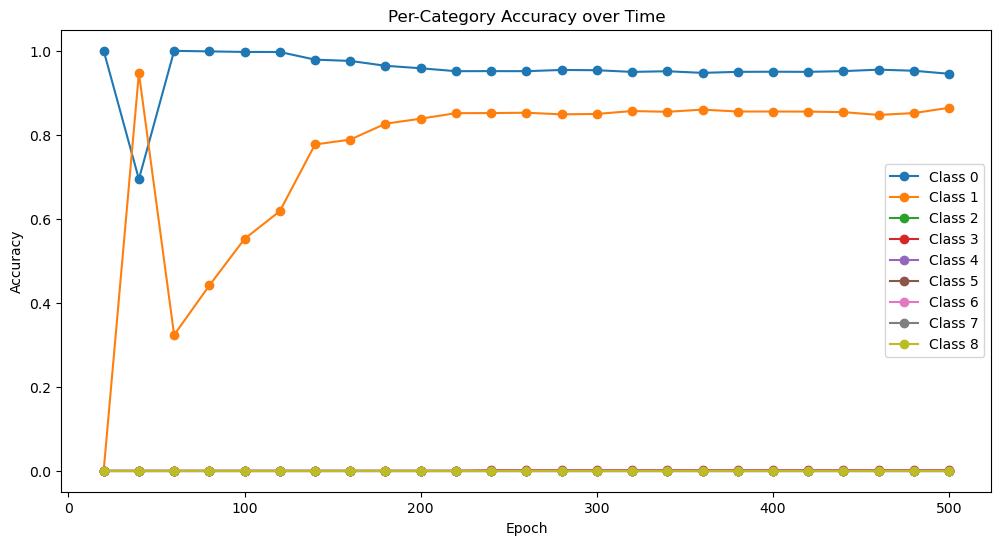

In [43]:
# Setting up the model, data, and the hyperparameters
data = data_cell_size
model = BaselineGCN(in_channels=data.x.shape[1], hidden_channels=16, num_classes=num_classes)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))

# GCN Model, SMOTE'd Cell Size + Connectivity Data

Epoch 020: Loss=1.9111, Test Loss=1.7076, Accuracy=0.4613, F1=0.0702
Epoch 040: Loss=1.7914, Test Loss=1.5533, Accuracy=0.1605, F1=0.0538
Epoch 060: Loss=1.7357, Test Loss=1.5573, Accuracy=0.1471, F1=0.0494
Epoch 080: Loss=1.7055, Test Loss=1.5340, Accuracy=0.1517, F1=0.0510
Epoch 100: Loss=1.6842, Test Loss=1.5223, Accuracy=0.1524, F1=0.0536
Epoch 120: Loss=1.6652, Test Loss=1.5107, Accuracy=0.1751, F1=0.0705
Epoch 140: Loss=1.6453, Test Loss=1.4997, Accuracy=0.2392, F1=0.1024
Epoch 160: Loss=1.6217, Test Loss=1.4787, Accuracy=0.3547, F1=0.1379
Epoch 180: Loss=1.5921, Test Loss=1.4553, Accuracy=0.4103, F1=0.1483
Epoch 200: Loss=1.5591, Test Loss=1.4309, Accuracy=0.4223, F1=0.1467
Epoch 220: Loss=1.5304, Test Loss=1.4036, Accuracy=0.4489, F1=0.1508
Epoch 240: Loss=1.5074, Test Loss=1.3818, Accuracy=0.4585, F1=0.1533
Epoch 260: Loss=1.4890, Test Loss=1.3670, Accuracy=0.4632, F1=0.1555
Epoch 280: Loss=1.4720, Test Loss=1.3509, Accuracy=0.4730, F1=0.1587
Epoch 300: Loss=1.4580, Test Loss=

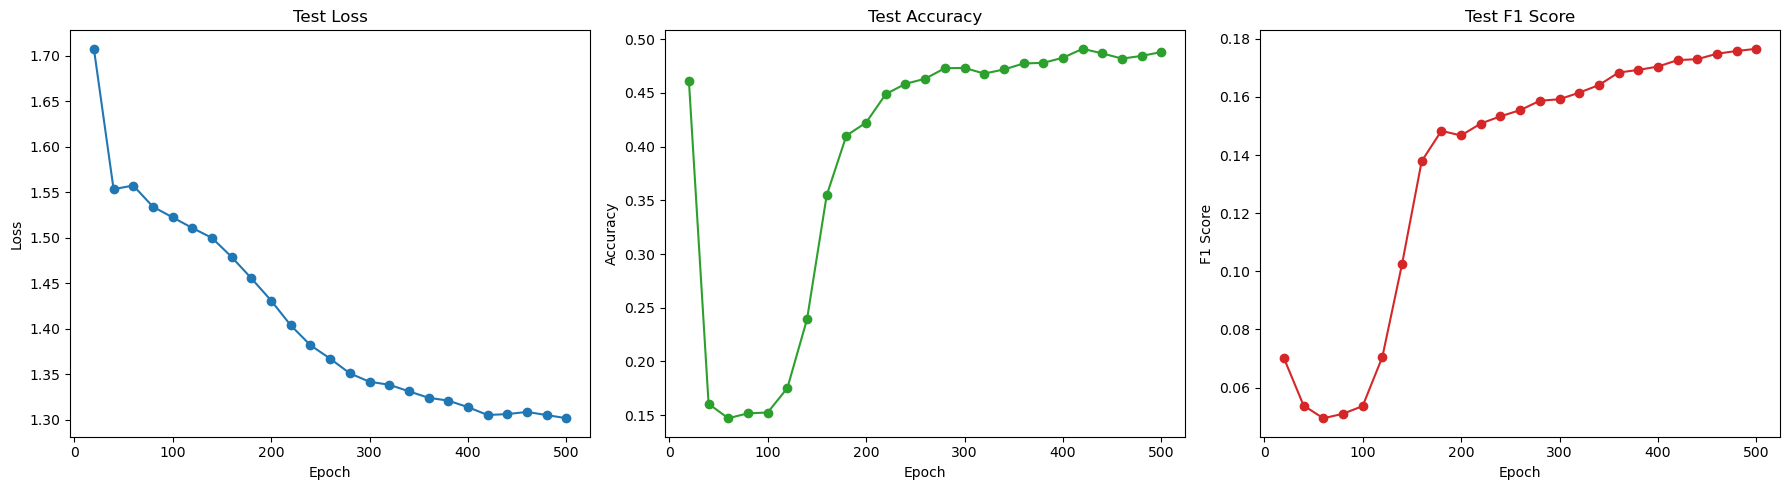

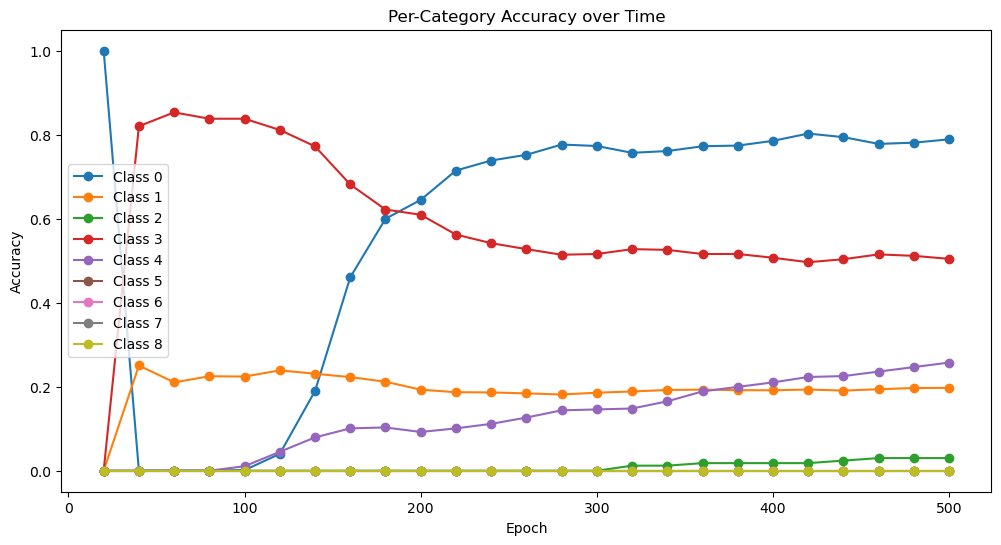

Class 0, final accuracy: 0.7890173410404624
Class 1, final accuracy: 0.19723300151847478
Class 2, final accuracy: 0.030120481927710843
Class 3, final accuracy: 0.5044483985765125
Class 4, final accuracy: 0.2575107296137339
Class 5, final accuracy: 0.0
Class 6, final accuracy: 0.0
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


In [48]:
# Setting up the model, data, and the hyperparameters
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = data_smote_cell_size.to(device)
model = BaselineGCN(in_channels=data.x.shape[1], hidden_channels=16, num_classes=num_classes).to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx_smote_cell_size)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

Epoch 020: Loss=1.4068, Test Loss=1.2977, Accuracy=0.4916, F1=0.1770
Epoch 040: Loss=1.4043, Test Loss=1.2976, Accuracy=0.4884, F1=0.1764
Epoch 060: Loss=1.4051, Test Loss=1.2968, Accuracy=0.4887, F1=0.1765
Epoch 080: Loss=1.4001, Test Loss=1.2999, Accuracy=0.4827, F1=0.1757
Epoch 100: Loss=1.3972, Test Loss=1.2971, Accuracy=0.4858, F1=0.1761
Epoch 120: Loss=1.3972, Test Loss=1.2962, Accuracy=0.4865, F1=0.1763
Epoch 140: Loss=1.4014, Test Loss=1.2958, Accuracy=0.4863, F1=0.1762
Epoch 160: Loss=1.3976, Test Loss=1.2960, Accuracy=0.4835, F1=0.1766
Epoch 180: Loss=1.3882, Test Loss=1.3033, Accuracy=0.4733, F1=0.1740
Epoch 200: Loss=1.3991, Test Loss=1.2962, Accuracy=0.4837, F1=0.1762
Epoch 220: Loss=1.3912, Test Loss=1.2904, Accuracy=0.4915, F1=0.1766
Epoch 240: Loss=1.3998, Test Loss=1.2911, Accuracy=0.4897, F1=0.1763
Epoch 260: Loss=1.4006, Test Loss=1.2891, Accuracy=0.4903, F1=0.1769
Epoch 280: Loss=1.3931, Test Loss=1.2878, Accuracy=0.4935, F1=0.1769
Epoch 300: Loss=1.3903, Test Loss=

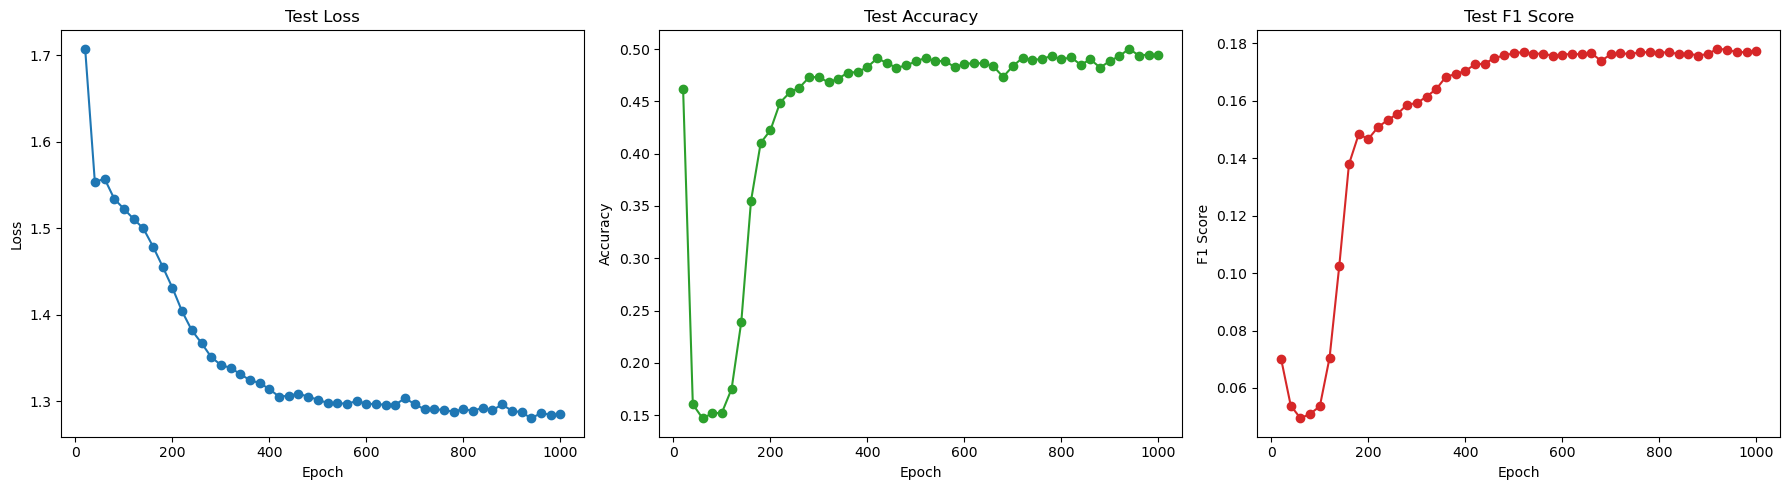

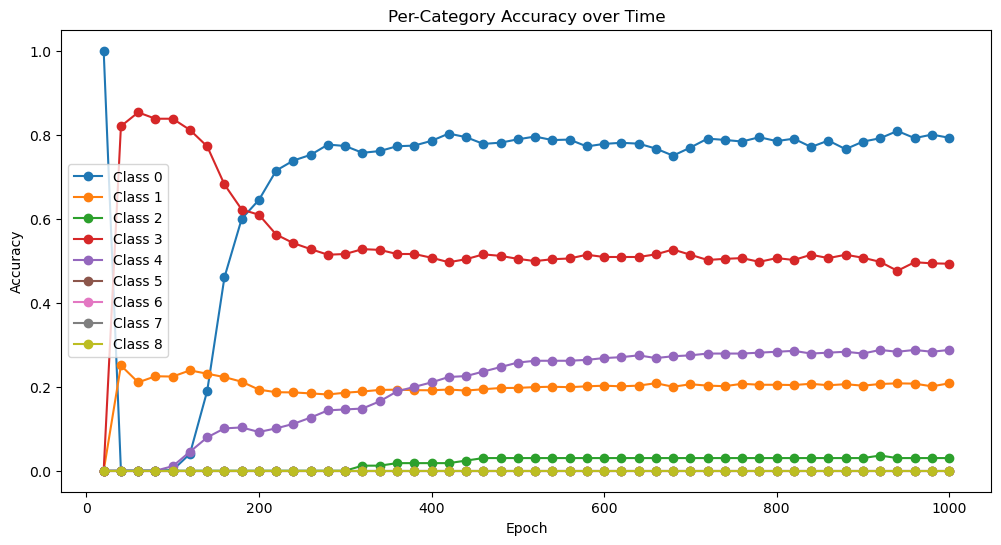

Class 0, final accuracy: 0.7927745664739885
Class 1, final accuracy: 0.20803104437320735
Class 2, final accuracy: 0.030120481927710843
Class 3, final accuracy: 0.4928825622775801
Class 4, final accuracy: 0.2875536480686695
Class 5, final accuracy: 0.0
Class 6, final accuracy: 0.0
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


In [49]:
for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx_smote_cell_size)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, 2*num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

# GCN Model, SMOTE'd Cell Size + Connectivity Data, ME Loss

Epoch 020: Loss=1.9894, Test Loss=1.8606, Accuracy=0.0749, F1=0.0155
Epoch 040: Loss=1.8568, Test Loss=1.5942, Accuracy=0.0749, F1=0.0155
Epoch 060: Loss=1.8051, Test Loss=1.6093, Accuracy=0.1238, F1=0.0408
Epoch 080: Loss=1.7721, Test Loss=1.5853, Accuracy=0.1413, F1=0.0475
Epoch 100: Loss=1.7421, Test Loss=1.5770, Accuracy=0.1497, F1=0.0526
Epoch 120: Loss=1.7221, Test Loss=1.5629, Accuracy=0.1683, F1=0.0635
Epoch 140: Loss=1.7045, Test Loss=1.5525, Accuracy=0.2341, F1=0.0973
Epoch 160: Loss=1.6753, Test Loss=1.5266, Accuracy=0.3572, F1=0.1292
Epoch 180: Loss=1.6331, Test Loss=1.4965, Accuracy=0.4143, F1=0.1379
Epoch 200: Loss=1.5946, Test Loss=1.4689, Accuracy=0.4281, F1=0.1407
Epoch 220: Loss=1.5661, Test Loss=1.4344, Accuracy=0.4515, F1=0.1455
Epoch 240: Loss=1.5360, Test Loss=1.4126, Accuracy=0.4597, F1=0.1497
Epoch 260: Loss=1.5141, Test Loss=1.4010, Accuracy=0.4567, F1=0.1488
Epoch 280: Loss=1.4967, Test Loss=1.3871, Accuracy=0.4666, F1=0.1545
Epoch 300: Loss=1.4863, Test Loss=

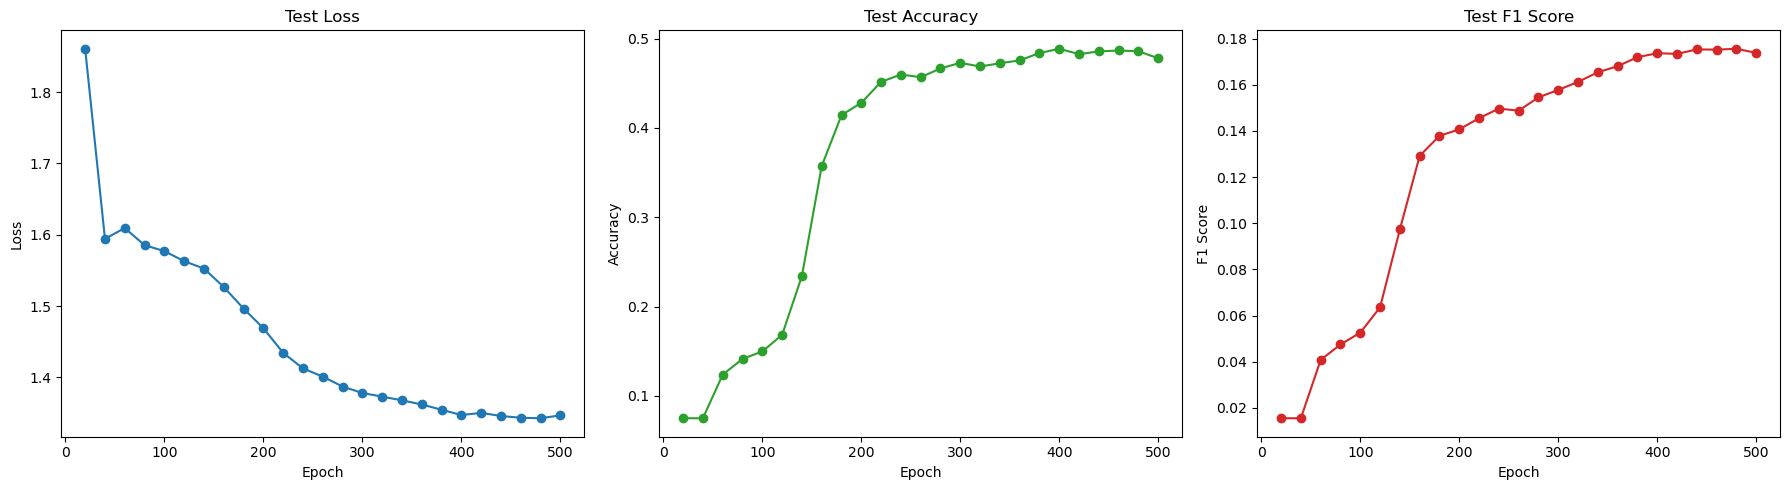

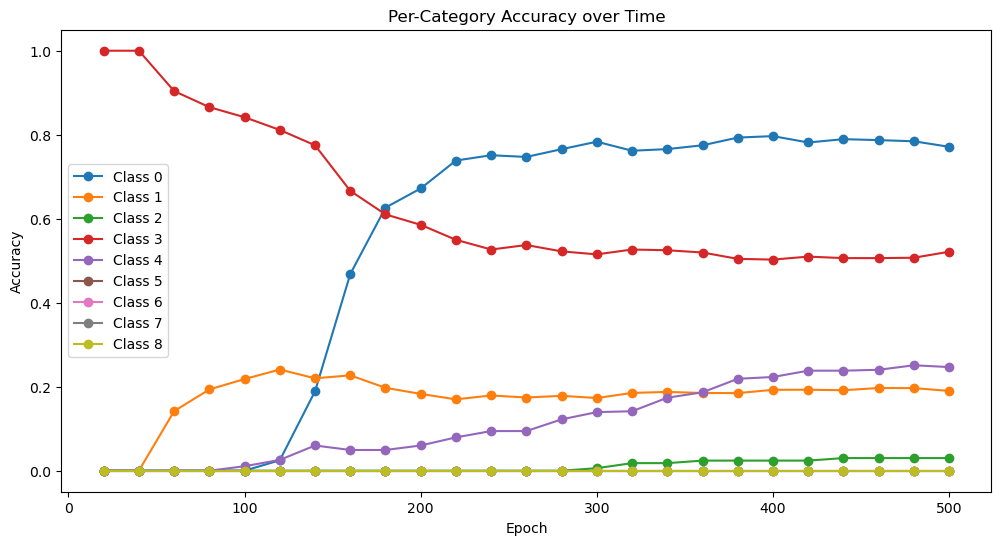

Class 0, final accuracy: 0.7712427745664739
Class 1, final accuracy: 0.18997806647545132
Class 2, final accuracy: 0.030120481927710843
Class 3, final accuracy: 0.5213523131672598
Class 4, final accuracy: 0.24678111587982832
Class 5, final accuracy: 0.0
Class 6, final accuracy: 0.0
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


In [47]:
# Setting up the model, data, and the hyperparameters
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = data_smote_cell_size.to(device)
model = BaselineGCN(in_channels=data.x.shape[1], hidden_channels=16, num_classes=num_classes).to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = ME(device=device, balancing_factor=0.3)
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx_smote_cell_size)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

# GraphSAGE Model, Cell Size + Connectivity Data

Epoch 020: Loss=1.3005, Test Loss=1.2554, Accuracy=0.4337, F1=0.1005
Epoch 040: Loss=1.2003, Test Loss=1.1713, Accuracy=0.4918, F1=0.0974
Epoch 060: Loss=1.1722, Test Loss=1.1447, Accuracy=0.4937, F1=0.0996
Epoch 080: Loss=1.1392, Test Loss=1.1219, Accuracy=0.5109, F1=0.1104
Epoch 100: Loss=1.1093, Test Loss=1.0884, Accuracy=0.5709, F1=0.1313
Epoch 120: Loss=1.0816, Test Loss=1.0506, Accuracy=0.6362, F1=0.1508
Epoch 140: Loss=1.0519, Test Loss=1.0170, Accuracy=0.6612, F1=0.1572
Epoch 160: Loss=1.0232, Test Loss=0.9858, Accuracy=0.6823, F1=0.1626
Epoch 180: Loss=0.9809, Test Loss=0.9597, Accuracy=0.7145, F1=0.1704
Epoch 200: Loss=0.9629, Test Loss=0.9338, Accuracy=0.7209, F1=0.1720
Epoch 220: Loss=0.9718, Test Loss=0.9161, Accuracy=0.7291, F1=0.1740
Epoch 240: Loss=0.9467, Test Loss=0.8994, Accuracy=0.7422, F1=0.1775
Epoch 260: Loss=0.9355, Test Loss=0.8858, Accuracy=0.7385, F1=0.1825
Epoch 280: Loss=0.9489, Test Loss=0.8729, Accuracy=0.7494, F1=0.2208
Epoch 300: Loss=0.9233, Test Loss=

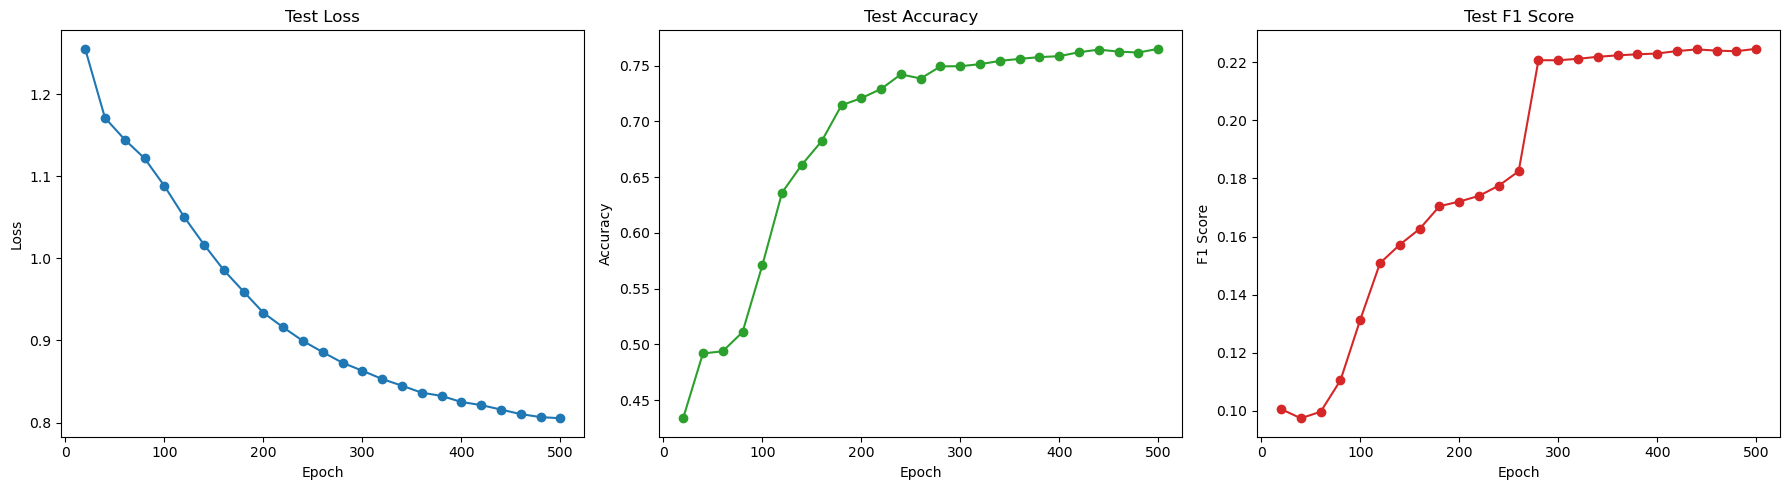

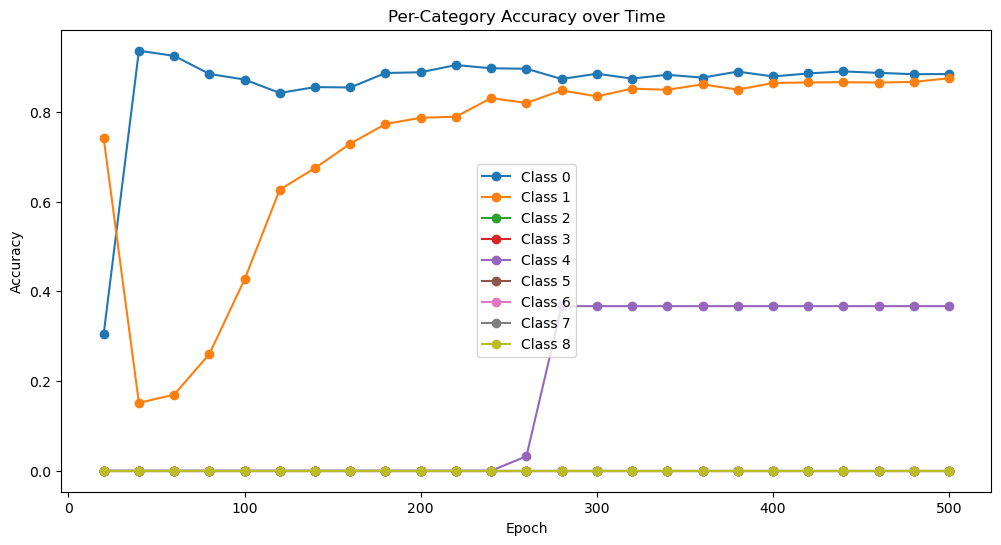

Class 0, final accuracy: 0.884393063583815
Class 1, final accuracy: 0.8749789100725494
Class 2, final accuracy: 0.0
Class 3, final accuracy: 0.0
Class 4, final accuracy: 0.3669527896995708
Class 5, final accuracy: 0.0
Class 6, final accuracy: 0.0
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


In [52]:
# Setting up the model, data, and the hyperparameters
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = data_cell_size.to(device)
model = GraphSAGE(in_channels=data.x.shape[1], hidden_channels=16, num_classes=num_classes).to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

# GraphSAGE Model, SMOTE'd Cell Size + Connectivity Data

Epoch 020: Loss=1.7486, Test Loss=1.5180, Accuracy=0.1069, F1=0.0299
Epoch 040: Loss=1.6940, Test Loss=1.5059, Accuracy=0.1809, F1=0.0839
Epoch 060: Loss=1.6610, Test Loss=1.4695, Accuracy=0.2424, F1=0.1011
Epoch 080: Loss=1.6185, Test Loss=1.4415, Accuracy=0.2734, F1=0.1133
Epoch 100: Loss=1.5717, Test Loss=1.3947, Accuracy=0.3050, F1=0.1241
Epoch 120: Loss=1.5321, Test Loss=1.3460, Accuracy=0.3823, F1=0.1432
Epoch 140: Loss=1.4847, Test Loss=1.3040, Accuracy=0.4316, F1=0.1570
Epoch 160: Loss=1.4355, Test Loss=1.2599, Accuracy=0.4871, F1=0.1861
Epoch 180: Loss=1.3985, Test Loss=1.2119, Accuracy=0.5293, F1=0.2063
Epoch 200: Loss=1.3713, Test Loss=1.2026, Accuracy=0.5277, F1=0.2090
Epoch 220: Loss=1.3331, Test Loss=1.1822, Accuracy=0.5397, F1=0.2128
Epoch 240: Loss=1.3148, Test Loss=1.1530, Accuracy=0.5604, F1=0.2154
Epoch 260: Loss=1.2765, Test Loss=1.1378, Accuracy=0.5716, F1=0.2189
Epoch 280: Loss=1.2669, Test Loss=1.1165, Accuracy=0.5945, F1=0.2313
Epoch 300: Loss=1.2375, Test Loss=

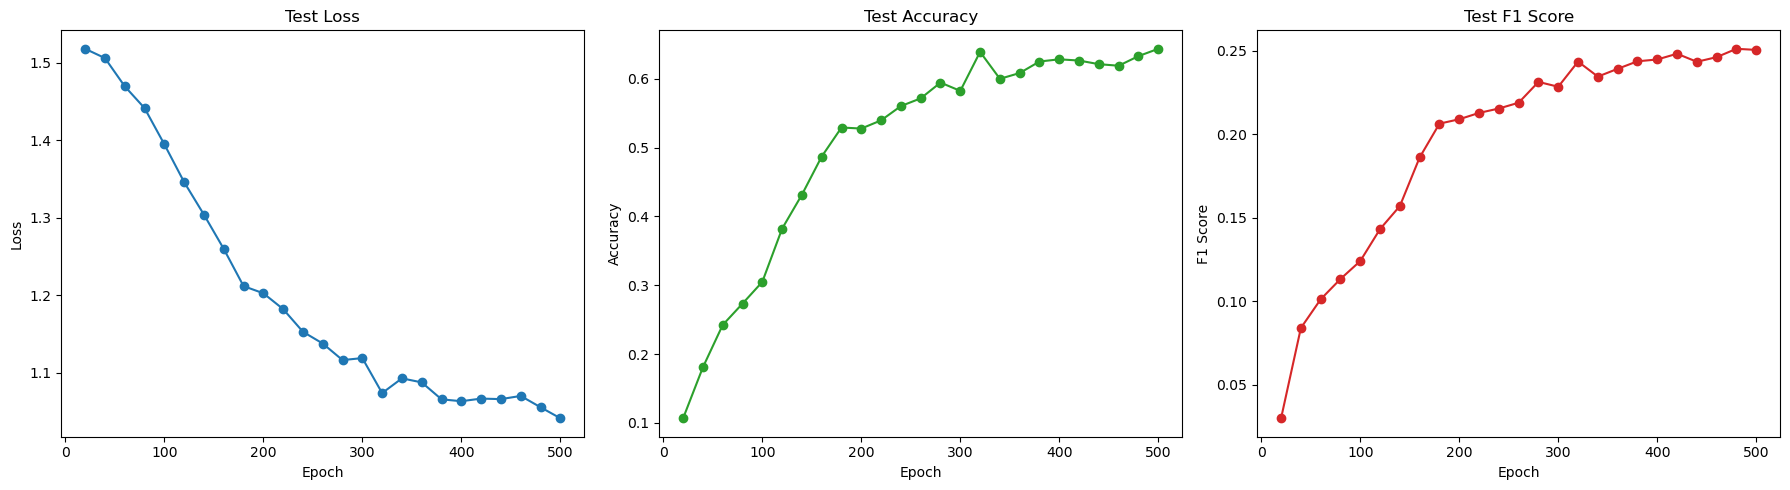

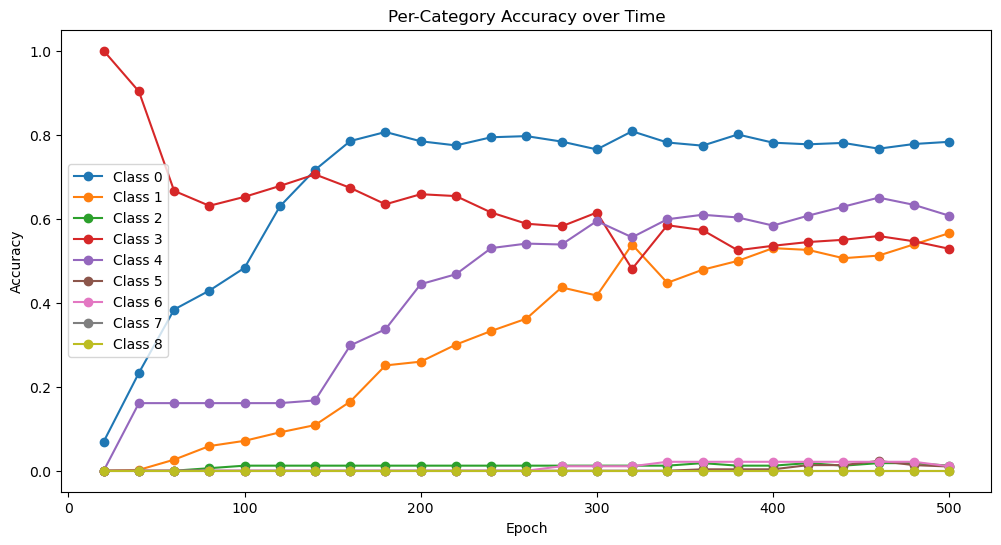

Class 0, final accuracy: 0.7830924855491329
Class 1, final accuracy: 0.5655474945166189
Class 2, final accuracy: 0.012048192771084338
Class 3, final accuracy: 0.5284697508896797
Class 4, final accuracy: 0.6072961373390557
Class 5, final accuracy: 0.01
Class 6, final accuracy: 0.010638297872340425
Class 7, final accuracy: 0.0
Class 8, final accuracy: 0.0


In [53]:
# Setting up the model, data, and the hyperparameters
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = data_smote_cell_size.to(device)
model = GraphSAGE(in_channels=data.x.shape[1], hidden_channels=16, num_classes=num_classes).to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx_smote_cell_size)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")

# GraphSAGE Model, SMOTE'd Cell Size + Connectivity Data, ME Loss

In [34]:
# Setting up the model, data, and the hyperparameters
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = data_smote_cell_size.to(device)
model = GraphSAGE(in_channels=data.x.shape[1], hidden_channels=16, num_classes=num_classes).to(device)
lr=0.01
weight_decay=5e-4
optimizer = get_optimizer(model, lr, weight_decay)
criterion = ME(device=device, balancing_factor=0.3)
num_epochs = 500
record_interval = 20

losses = []
test_losses = []
test_accuracies = []
test_f1s = []
per_class_acc_history = []
f1_per_class_history = []

for epoch in range(1, num_epochs + 1):
    # Train the model every epoch
    loss = train(model, data, optimizer, criterion, train_idx_smote_cell_size)
    losses.append(loss)
    
    if epoch % record_interval == 0:
        # Evaluate overall metrics
        test_loss, test_acc, test_f1, test_per_class_acc = test(model, data, optimizer, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)
        per_class_acc_history.append(test_per_class_acc)
        f1_per_class_history.append(f1_per_class(model, data, optimizer, criterion))
        
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Test Loss={test_loss:.4f}, Accuracy={test_acc:.4f}, F1={test_f1:.4f}')

# Plot the results
epochs_recorded = np.arange(record_interval, num_epochs + 1, record_interval)
plot_experiment_results(epochs_recorded, test_losses, test_accuracies, test_f1s)
plot_experiment_results_per_class(epochs_recorded, np.array(per_class_acc_history))
plot_f1_per_class(epochs_recorded, np.array(f1_per_class_history))

print("\n\n")
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final accuracy: {per_class_acc_history[-1][i]}")
print("\n\n")
for i in range(len(per_class_acc_history[-1])):
    print(f"Class {i}, final f1 score: {per_class_acc_history[-1][i]}")

TypeError: GraphSAGE.forward() takes 2 positional arguments but 3 were given